# 0.0. IMPORTS

In [22]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import requests
import warnings
import inflection
import yaml
import seaborn as sns
import xgboost as xgb

from datetime                   import datetime
from scipy                      import stats  as ss
from boruta                     import BorutaPy
from matplotlib                 import pyplot as plt
from datetime                   import datetime, timedelta
from IPython.display            import Image
from IPython.core.display       import HTML
from multiprocessing            import cpu_count
from tabulate                   import tabulate
from copy                       import deepcopy

from sklearn.base               import clone, BaseEstimator, TransformerMixin
from sklearn.model_selection    import GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.pipeline           import Pipeline
from sklearn.compose            import ColumnTransformer
from sklearn.impute             import KNNImputer
from sklearn.metrics            import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.ensemble           import RandomForestRegressor
from sklearn.linear_model       import LinearRegression, Lasso
from sklearn.preprocessing      import RobustScaler, MinMaxScaler, LabelEncoder, FunctionTransformer, OneHotEncoder

import utils


## 0.1. Helper Functions

In [ ]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    """
    Performs k-fold cross-validation for a given model.

    Parameters:
    - x_training (DataFrame): Training dataset containing features and target variable.
    - kfold (int): Number of folds for cross-validation.
    - model_name (str): Name of the model.
    - model: Machine learning model object with `fit` and `predict` methods.
    - verbose (bool, optional): If True, print information for each fold. Default is False.

    Returns:
    - DataFrame: A DataFrame containing cross-validation results including mean and standard deviation of MAE, MAPE, and RMSE.
    """
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


In [ ]:
def mean_percentage_error( y, yhat ):
    """
    Calculates the mean percentage error between actual and predicted values.

    Parameters:
    - y (array-like): Array of actual target values.
    - yhat (array-like): Array of predicted target values.

    Returns:
    - float: Mean percentage error.
    """
    return np.mean( ( y - yhat ) / y )

In [ ]:
def mean_absolute_percentage_error( y, yhat ):
    """
    Calculates the mean absolute percentage error between actual and predicted values.

    Parameters:
    - y (array-like): Array of actual target values.
    - yhat (array-like): Array of predicted target values.

    Returns:
    - float: Mean absolute percentage error.
    """
    return np.mean( np.abs( ( y - yhat ) / y ) )

In [ ]:
def ml_error( model_name, y, yhat ):
    """
    Calculate evaluation metrics for a machine learning model.

    Parameters:
    - model_name (str): Name of the model.
    - y (array-like): Array of actual target values.
    - yhat (array-like): Array of predicted target values.

    Returns:
    - DataFrame: DataFrame containing evaluation metrics (MAE, MAPE, RMSE) for the model.
    """
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

In [ ]:
def cramer_v( x, y ):
    """
    Calculates Cramer's V statistic for categorical-categorical association.

    Parameters:
    - x (array-like): Array or Series containing categorical data.
    - y (array-like): Array or Series containing categorical data.

    Returns:
    - float: Cramer's V statistic.
    """
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [ ]:
def jupyter_settings():
    """
    Configure settings for Jupyter Notebook environment.

    This function sets up the following configurations:
    - Inline matplotlib plots
    - 'bmh' style for plots
    - Adjusted figure size and font size for plots
    - Expanded display for pandas DataFrame
    - Set seaborn defaults

    """
    %matplotlib inline
    # %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [1]:
def import_config(path_yaml):
    '''
    Import configuration settings from a YAML file.

    Parameters:
    - path_yaml (str): The path to the YAML configuration file.

    Returns:
    - dict: A dictionary containing the configuration settings loaded from the YAML file.

    Example:
    # config = import_config('config.yaml')
    # print(config)
    {'key1': 'value1', 'key2': 'value2', ...}
    '''
    with open(path_yaml) as config_file:
        config = yaml.safe_load(config_file)
    return config

In [3]:
jupyter_settings()

### 0.1.2. Config

The _'yaml'_ file will act as a shortcut for a few functions to optimize both the code and the process of coding.

In [4]:
config = import_config('config.yaml')
config

{'split': {'seed': 42, 'test_size': 0.2},
 'data': {'raw_path': '../data/raw/raw_data.csv',
  'trusted_path': '../data/df1_no_nas.csv',
  'train_path': '../data/train.csv',
  'test_path': '../data/test.csv',
  'store_path': '../data/store.csv',
  'trusted2_path': '../data/trusted.csv',
  'val_path': '../data/x_val_nonas.csv'},
 'image': {'path': '../images/mind_map.png'}}

## 0.2. Loading data

Load code from source and merge the two data frames of interest.

In [10]:
# Load raw data
df_sales_raw = pd.read_csv( config['data']['train_path'], low_memory=False )
df_store_raw = pd.read_csv( config['data']['store_path'], low_memory=False )

# merge DataFrames
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )


In [79]:
df_raw.shape

(1017209, 18)

Create a class to format the columns in the data frame. The goal is to optimize the coding process.

In [12]:
# Class to format the raw data frame

class FormatRawColumns_(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = self.rename_columns(X)

        return X
    
    def rename_columns(self, dataframe):
        # Copy the data frame
        df = dataframe.copy()

        # List the columns names
        cols_raw = list(df.columns)

        # Convert headers to snakecase format
        snakecase = lambda x: inflection.underscore( x )

        # Implement new column names
        cols_new = list( map( snakecase, cols_raw ) )

        # replace the dataframe column names with the newly formatted names
        df.columns = cols_new

        return df

Instantiate the pipeline for column formatting.

In [23]:
# Create a pipeline to rename the data frame
format_data_pipe = Pipeline([
    ("rename", utils.FormatRawColumns())
])

Use the class to format column names, convert the date to appropriate format.

In [27]:
# Rename dataframe columns using Pipeline
df_raw = format_data_pipe.fit_transform(df_raw)
df_raw['date'] = pd.to_datetime(df_raw['date'])
df_raw = df_raw.loc[df_raw['sales']!=0,]
df_raw.head()

store  day_of_week       date  sales  customers  open  promo state_holiday  school_holiday store_type assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year   promo_interval
0      1            5 2015-07-31   5263        555     1      1             0               1          c          a                1270.0                           9.0                       2008.0       0                NaN                NaN              NaN
1      2            5 2015-07-31   6064        625     1      1             0               1          a          a                 570.0                          11.0                       2007.0       1               13.0             2010.0  Jan,Apr,Jul,Oct
2      3            5 2015-07-31   8314        821     1      1             0               1          a          a               14130.0                          12.0                       2006.0       1               14.0             2011.0  Jan,Apr,Jul,Oct
3      4            5 2015-07-31  13995       1498     1      1             0               1          c          c                 620.0                           9.0                       2009.0       0                NaN                NaN              NaN
4      5            5 2015-07-31   4822        559     1      1             0               1          a          a               29910.0                           4.0                       2015.0       0                NaN                NaN              NaN

In [41]:
dt_field = [
['header','description'],
['Id                              '    , 'an Id that represents a (Store, Date) duple within the test set'],                                                                                                                                                                          
['Store                           '    , 'a unique Id for each store'],
['Day of Week                     '    , 'Corresponding day of the week for the date'],
['Date                            '    , 'The date of the register'],
['Sales                           '    , 'the turnover for any given day (this is what you are predicting)'],
['Customers                       '    , 'the number of customers on a given day'],
['Open                            '    , 'an indicator for whether the store was open: 0 = closed, 1 = open'],
['StateHoliday                    '    , 'indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, d = None'],
['SchoolHoliday                   '    , 'indicates if the (Store, Date) was affected by the closure of public schools'],
['StoreType                       '    , 'differentiates between 4 different store models: a, b, c, d'],
['Assortment                      '    , 'describes an assortment level: a = basic, b = extra, c = extended'],
['CompetitionDistance             '    , 'distance in meters to the nearest competitor store'],
['CompetitionOpenSince[Month/Year]'    , 'gives the approximate year and month of the time the nearest competitor was opened'],
['Promo                           '    , 'indicates whether a store is running a promo on that day'],
['Promo2                          '    , 'Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating'],
['Promo2Since[Year/Week]          '    , 'describes the year and calendar week when the store started participating in Promo2'],
['PromoInterval                   '    , 'describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store']
]
print('Description of the studied variables.\n')
print('* * * ** * * ** * * ** * * ** * * ** * * ** * * ** * * ** * * ** * * ** * * ** * * *\n')
print( tabulate( dt_field, headers='firstrow' ) )

Description of the studied variables.

* * * ** * * ** * * ** * * ** * * ** * * ** * * ** * * ** * * ** * * ** * * ** * * *

header                            description
--------------------------------  ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Id                                an Id that represents a (Store, Date) duple within the test set
Store                             a unique Id for each store
Day of Week                       Corresponding day of the week for the date
Date                              The date of the register
Sales                             the turnover for any given day (this is what you are predicting)
Customers                         the number of customers on a given day
Open                              an indicator for whether the store was open: 0 = closed, 1 = open

## 0.3. Split Data into Training, Validation, and Test sets

This project deals with time-dependent data and requires proper partitioning techniques. Also, the business problem is looking for a 6-week estimation. Therefore, I am seeparating the test set with the last 6 weeks of the data set. For the remaining data, I am using chronological split with a 70%:30% ratio for the train and validation split, respectively. The goal with this technique is to preserve the temporal dependencies and trends in the data, while also simulating real-world scenarios where the model encounters actual data.

Finding the Minimum and Maximal dates in the dataset

In [81]:
print(f"Date min: {df_raw['date'].min()}")
print(f"Date max: {df_raw['date'].max()}")

Date min: 2013-01-01 00:00:00
Date max: 2015-07-31 00:00:00


Calculate the number of weeks between the first and the last day registered in the data set

In [82]:
week_diff = (df_raw['date'].max() - df_raw['date'].min())/ np.timedelta64(1,'W')
week_diff = round(week_diff)
print(week_diff)

134


Calculate the number of weeks each portion of the split should have

In [83]:
full_data = week_diff
train = 0.7
val = 0.3
test = 128
print(f'Test portion should have {full_data-test:.1f} weeks')
print(f'Validation portion should have {full_data*val:.1f} weeks')
print(f'Train portion should have {full_data*train:.1f} weeks')

Test portion should have 6.0 weeks
Validation portion should have 40.2 weeks
Train portion should have 93.8 weeks


Calculate the time windows for each partition

In [84]:
# Constants
test_weeks = 6
wts = 40
roof_val = pd.to_datetime('2015-06-18 00:00:00')
roof_train = pd.to_datetime('2014-09-10 00:00:00')

# Calculations
date_test = df_raw['date'].max()
floor_test = date_test - pd.Timedelta(weeks=test_weeks)
floor_val = roof_val - pd.Timedelta(weeks=wts)

# Output
print(f'Date max:                       {date_test}')
print(f'Window for test split:          {floor_test} and {date_test}')
print(f'Window for validation split:    {floor_val} and {roof_val}')
print(f'Window for train split: between {df_raw["date"].min()} and {roof_train}')


Date max:                       2015-07-31 00:00:00
Window for test split:          2015-06-19 00:00:00 and 2015-07-31 00:00:00
Window for validation split:    2014-09-11 00:00:00 and 2015-06-18 00:00:00
Window for train split: between 2013-01-01 00:00:00 and 2014-09-10 00:00:00


Splitting the original dataset into train, validation, and test

In [85]:
# Training dataset
X_train = df_raw[df_raw['date'] <= '2014-09-10']
y_train = X_train['sales']

# Validation dataset
X_val = df_raw[(df_raw['date'] >= '2014-09-11') & (df_raw['date'] <= '2015-06-18')]
y_val = X_val['sales']

# Test dataset
X_test = df_raw[df_raw['date'] >= '2015-06-19']
y_test = X_test['sales']

print( f'Training Min Date: {X_train["date"].min()}')
print( f'Training Max Date: {X_train["date"].max()}')

print( f'\nValidation Min Date: {X_val["date"].min()}')
print( f'Validation Max Date: {X_val["date"].max()}')

print( f'\nTest Min Date: {X_test["date"].min()}')
print( f'Test Max Date: {X_test["date"].max()}')

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2014-09-10 00:00:00

Validation Min Date: 2014-09-11 00:00:00
Validation Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


In [34]:
print(f'\nTrain Shape:{X_train.shape} --> {np.round((X_train.shape[0]/df_raw.shape[0])*100, 1)}% of raw data')
print(f'\nValidation Shape:{X_val.shape} --> {np.round((X_val.shape[0]/df_raw.shape[0])*100, 1)}% of raw data')
print(f'\nTest Shape:{X_test.shape} --> {np.round((X_test.shape[0]/df_raw.shape[0])*100, 1)}% of raw data')


Train Shape:(676109, 18) --> 66.5% of raw data

Validation Shape:(293155, 18) --> 28.8% of raw data

Test Shape:(47945, 18) --> 4.7% of raw data


# 1.0. Data Description

In [35]:
X_train.head()

store  day_of_week       date  sales  customers  open  promo state_holiday  school_holiday store_type assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year   promo_interval
341100      1            3 2014-09-10   3275        448     1      0             0               0          c          a                1270.0                           9.0                       2008.0       0                NaN                NaN              NaN
341101      2            3 2014-09-10   4865        646     1      0             0               0          a          a                 570.0                          11.0                       2007.0       1               13.0             2010.0  Jan,Apr,Jul,Oct
341102      3            3 2014-09-10   5164        659     1      0             0               0          a          a               14130.0                          12.0                       2006.0       1               14.0             2011.0  Jan,Apr,Jul,Oct
341103      4            3 2014-09-10   8530       1206     1      0             0               0          c          c                 620.0                           9.0                       2009.0       0                NaN                NaN              NaN
341104      5            3 2014-09-10   4305        590     1      0             0               0          a          a               29910.0                           4.0                       2015.0       0                NaN                NaN              NaN

## 1.1. Data Types

Verify whether the data types need ay formatting. 

In [86]:
print(X_train.info())
print(X_val.info())

<class 'pandas.core.frame.DataFrame'>
Index: 561576 entries, 341100 to 1017190
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   store                         561576 non-null  int64         
 1   day_of_week                   561576 non-null  int64         
 2   date                          561576 non-null  datetime64[ns]
 3   sales                         561576 non-null  int64         
 4   customers                     561576 non-null  int64         
 5   open                          561576 non-null  int64         
 6   promo                         561576 non-null  int64         
 7   state_holiday                 561576 non-null  object        
 8   school_holiday                561576 non-null  int64         
 9   store_type                    561576 non-null  object        
 10  assortment                    561576 non-null  object        
 11  competition_

## 1.2. Missing Data

Checking whether the data present missing information

In [87]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(f'Missing train data:\n{X_train.isna().sum()/X_train.shape[0]*100}')


Missing train data:
store                            0.000000
day_of_week                      0.000000
date                             0.000000
sales                            0.000000
customers                        0.000000
open                             0.000000
promo                            0.000000
state_holiday                    0.000000
school_holiday                   0.000000
store_type                       0.000000
assortment                       0.000000
competition_distance             0.262832
competition_open_since_month    31.795696
competition_open_since_year     31.795696
promo2                           0.000000
promo2_since_week               49.653297
promo2_since_year               49.653297
promo_interval                  49.653297
dtype: float64


In [88]:
print(f'Missing validation data:\n{X_val.isna().sum()/X_val.shape[0]*100}')

Missing validation data:
store                            0.000000
day_of_week                      0.000000
date                             0.000000
sales                            0.000000
customers                        0.000000
open                             0.000000
promo                            0.000000
state_holiday                    0.000000
school_holiday                   0.000000
store_type                       0.000000
assortment                       0.000000
competition_distance             0.248171
competition_open_since_month    31.857014
competition_open_since_year     31.857014
promo2                           0.000000
promo2_since_week               51.460438
promo2_since_year               51.460438
promo_interval                  51.460438
dtype: float64


* 6 variables presented missing data. Only one variable presented less than 10 % missing. Two variables present about 31% of missing whereas 3 variables present 49 - 51% missing. The decision to either imput data or remove the variables will be made after the exploratory data analysis phase of this project.

## 1.3. Check Duplicates

Checking for duplicated data.

In [9]:
# Duplicates in train set
(X_train.duplicated().sum() / X_train.shape[0]) * 100

0.0

In [10]:
# Duplicates in validation set
(X_val.duplicated().sum() / X_val.shape[0]) * 100

0.0

* Data do not have any duplicates.

## 1.4. Descriptive Statistics

This is the initial glimpse on the data sets. Such initial analysis aims to help understand in the next steps of the project.

First, separate the numerical and categorical variables.

In [89]:
# Train set
num_attributes_train = X_train.select_dtypes( include=['int64', 'float64'] )
cat_attributes_train = X_train.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

In [90]:
# Validation set
num_attributes_val = X_val.select_dtypes( include=['int64', 'float64'] )
cat_attributes_val = X_val.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.4.1. Numerical attributes

Perform basic descriptive statistics on the data.

**Train data**

In [91]:
# Central Tendency - mean, medianS 
ct1 = pd.DataFrame( num_attributes_train.apply( np.mean ).round(decimals=2) ).T
ct2 = pd.DataFrame( num_attributes_train.apply( np.median ).round(decimals=2) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes_train.apply( np.std ).round(decimals=2) ).T 
d2 = pd.DataFrame( num_attributes_train.apply( min ).round(decimals=2) ).T 
d3 = pd.DataFrame( num_attributes_train.apply( max ).round(decimals=2) ).T 
d4 = pd.DataFrame( num_attributes_train.apply( lambda x: x.max() - x.min() ).round(decimals=2) ).T 
d5 = pd.DataFrame( num_attributes_train.apply( lambda x: x.skew() ).round(decimals=2) ).T 
d6 = pd.DataFrame( num_attributes_train.apply( lambda x: x.kurtosis() ).round(decimals=2) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

attributes     min      max    range     mean  median      std  skew  kurtosis
0                          store     1.0   1115.0   1114.0   558.24   558.0   321.67  0.00     -1.20
1                    day_of_week     1.0      7.0      6.0     3.52     3.0     1.73  0.01     -1.26
2                          sales   133.0  38037.0  37904.0  6836.73  6250.0  3077.91  1.63      5.10
3                      customers    18.0   7388.0   7370.0   759.10   672.0   401.12  2.76     13.17
4                           open     1.0      1.0      0.0     1.00     1.0     0.00  0.00      0.00
5                          promo     0.0      1.0      1.0     0.43     0.0     0.50  0.26     -1.93
6                 school_holiday     0.0      1.0      1.0     0.21     0.0     0.41  1.43      0.05
7           competition_distance    20.0  75860.0  75840.0  5449.83     NaN  7789.82  2.97     13.43
8   competition_open_since_month     1.0     12.0     11.0     7.23     NaN     3.21 -0.17     -1.24
9    competition_open_since_year  1900.0   2015.0    115.0  2008.69     NaN     6.06 -7.72    124.41
10                        promo2     0.0      1.0      1.0     0.50     1.0     0.50 -0.01     -2.00
11             promo2_since_week     NaN      NaN     49.0    23.39     NaN    14.12  0.09     -1.38
12             promo2_since_year     NaN      NaN      6.0  2011.76     NaN     1.67 -0.12     -1.05

**Validation Data**

In [92]:
# Central Tendency - mean, medianS 
ct1 = pd.DataFrame( num_attributes_val.apply( np.mean ).round(decimals=2) ).T
ct2 = pd.DataFrame( num_attributes_val.apply( np.median ).round(decimals=2) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes_val.apply( np.std ).round(decimals=2) ).T 
d2 = pd.DataFrame( num_attributes_val.apply( min ).round(decimals=2) ).T 
d3 = pd.DataFrame( num_attributes_val.apply( max ).round(decimals=2) ).T 
d4 = pd.DataFrame( num_attributes_val.apply( lambda x: x.max() - x.min() ).round(decimals=2) ).T 
d5 = pd.DataFrame( num_attributes_val.apply( lambda x: x.skew() ).round(decimals=2) ).T 
d6 = pd.DataFrame( num_attributes_val.apply( lambda x: x.kurtosis() ).round(decimals=2) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

attributes     min      max    range     mean  median      std  skew  kurtosis
0                          store     1.0   1115.0   1114.0   558.90   558.0   321.86 -0.00     -1.20
1                    day_of_week     1.0      7.0      6.0     3.50     3.0     1.72  0.04     -1.25
2                          sales    46.0  38722.0  38676.0  7226.63  6638.0  3156.37  1.52      4.38
3                      customers     8.0   5494.0   5486.0   776.23   689.0   403.50  2.81     13.34
4                           open     1.0      1.0      0.0     1.00     1.0     0.00  0.00      0.00
5                          promo     0.0      1.0      1.0     0.48     0.0     0.50  0.10     -1.99
6                 school_holiday     0.0      1.0      1.0     0.14     0.0     0.34  2.12      2.51
7           competition_distance    20.0  75860.0  75840.0  5481.08     NaN  7862.76  2.97     13.34
8   competition_open_since_month     1.0     12.0     11.0     7.22     NaN     3.21 -0.17     -1.26
9    competition_open_since_year  1900.0   2015.0    115.0  2008.72     NaN     5.75 -6.84    111.96
10                        promo2     0.0      1.0      1.0     0.49     0.0     0.50  0.06     -2.00
11             promo2_since_week     NaN      NaN     49.0    22.87     NaN    14.05  0.14     -1.34
12             promo2_since_year     NaN      NaN      6.0  2011.74     NaN     1.65 -0.12     -1.01

Both train and validation datasets presented close scores, suggesting that the split of the data being able to maintain the original characteristics of both trin and validation data sets.

### 1.4.2. Categorical attributes

Cheking the unique values for the categorical variables.

In [113]:
print(f"State holiday uniques: {X_train['state_holiday'].unique()}\n")
print(f"Store type uniques: {X_train['store_type'].unique()}\n")
print(f"Assortment uniques: {X_train['assortment'].unique()}\n")
print(f"Promo interval uniques: {X_train['promo_interval'].unique()}")

State holiday uniques: ['regular_day' 'public_holiday' 'easter_holiday' 'christmas']

Store type uniques: ['c' 'a' 'd' 'b']

Assortment uniques: ['basic' 'extended' 'extra']

Promo interval uniques: [nan 'Jan,Apr,Jul,Oct' 'Mar,Jun,Sept,Dec' 'Feb,May,Aug,Nov']


Label variables for clarity:

In [ ]:
# Assortment
X_train["assortment"] = X_train["assortment"].apply(
    lambda x: (
        "basic"
        if x == "a"
        else (
            "extra" 
            if x == "b" 
            else "extended"
            )
        )
    )

# state holiday
X_train["state_holiday"] = X_train["state_holiday"].apply(
    lambda x: (
        "public_holiday"
        if x == "a"
        else (
            "easter_holiday" 
            if x == "b" 
            else (
                "christmas"
                if x == "c"
                else "regular_day"
            )
        )
    )
)

In [95]:
print(f"State holiday uniques: {X_train['state_holiday'].unique()}\n")
print(f"Store type uniques: {X_train['store_type'].unique()}\n")
print(f"Assortment uniques: {X_train['assortment'].unique()}\n")
print(f"Promo interval uniques: {X_train['promo_interval'].unique()}\n")

State holiday uniques: ['regular_day' 'public_holiday' 'easter_holiday' 'christmas']

Store type uniques: ['c' 'a' 'd' 'b']

Assortment uniques: ['basic' 'extended' 'extra']

Promo interval uniques: [nan 'Jan,Apr,Jul,Oct' 'Mar,Jun,Sept,Dec' 'Feb,May,Aug,Nov']



In [114]:
print(f"State holiday uniques: {X_val['state_holiday'].unique()}\n")
print(f"Store type uniques: {X_val['store_type'].unique()}\n")
print(f"Assortment uniques: {X_val['assortment'].unique()}\n")
print(f"Promo interval uniques: {X_val['promo_interval'].unique()}\n")

State holiday uniques: ['regular_day']

Store type uniques: ['c' 'a' 'd' 'b']

Assortment uniques: ['extended']

Promo interval uniques: [nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']



In [100]:
# Assortment
X_val["assortment"] = X_val["assortment"].apply(
    lambda x: (
        "basic"
        if x == "a"
        else (
            "extra" 
            if x == "b" 
            else "extended"
            )
        )
    )

# state holiday
X_val["state_holiday"] = X_val["state_holiday"].apply(
    lambda x: (
        "public_holiday"
        if x == "a"
        else (
            "easter_holiday" 
            if x == "b" 
            else (
                "christmas"
                if x == "c"
                else "regular_day"
            )
        )
    )
)

/tmp/ipykernel_96653/705530222.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val["assortment"] = X_val["assortment"].apply(
/tmp/ipykernel_96653/705530222.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val["state_holiday"] = X_val["state_holiday"].apply(


In [101]:
print(f"State holiday uniques: {X_val['state_holiday'].unique()}\n")
print(f"Store type uniques: {X_val['store_type'].unique()}\n")
print(f"Assortment uniques: {X_val['assortment'].unique()}\n")
print(f"Promo interval uniques: {X_val['promo_interval'].unique()}\n")

State holiday uniques: ['regular_day']

Store type uniques: ['c' 'a' 'd' 'b']

Assortment uniques: ['extended']

Promo interval uniques: [nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']



**Train Data**

Box plotting the sales by each of the categorical characteristics.

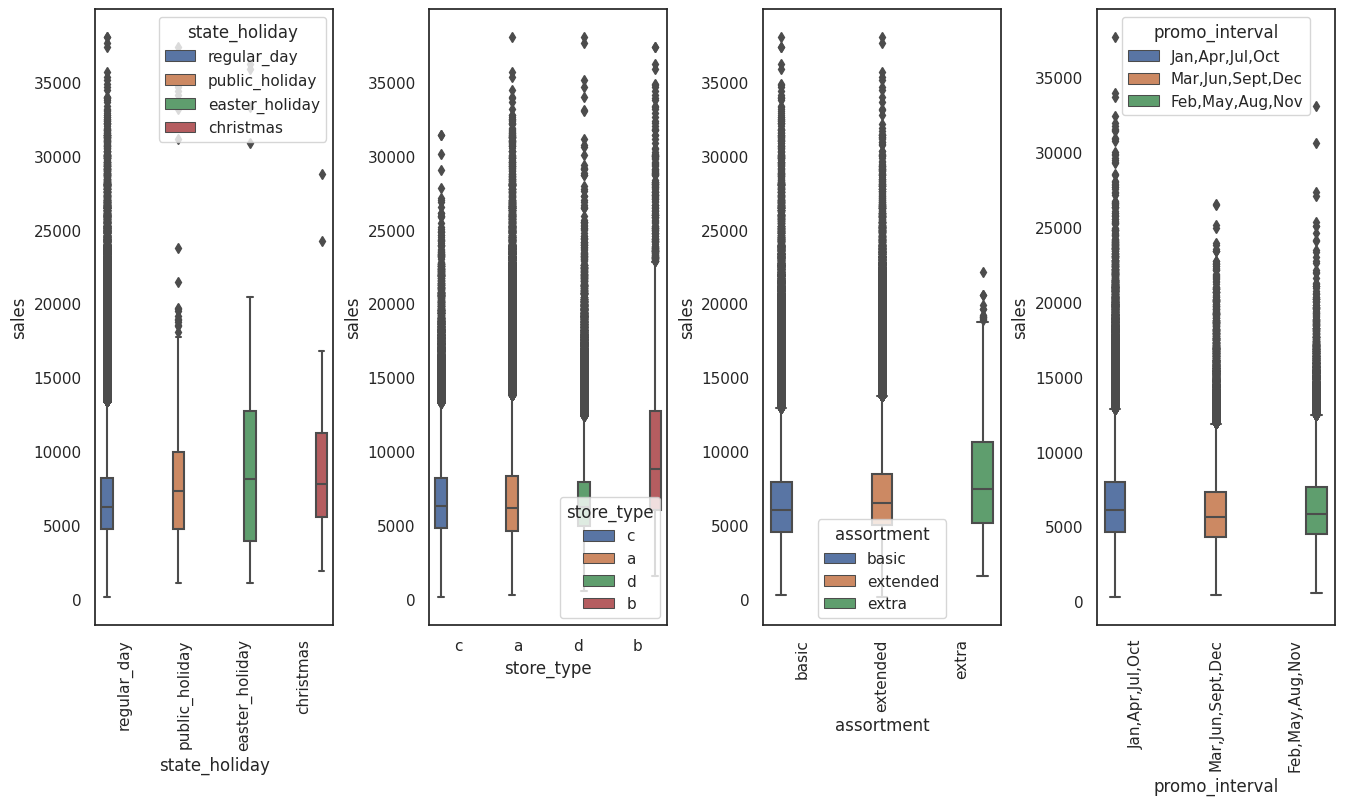

In [102]:
plt.figure(figsize=(16,8))

plt.subplot( 1, 4, 1 )
sns.set_style(style='white')
sns.boxplot( x='state_holiday', y='sales', data=X_train, hue = 'state_holiday' )
plt.xticks( rotation = 90)

plt.subplot( 1, 4, 2 )
sns.boxplot( x='store_type', y='sales', data=X_train, hue = 'store_type' )
sns.set_style(style='white')

plt.subplot( 1, 4, 3 )
sns.boxplot( x='assortment', y='sales', data=X_train, hue = 'assortment' )
sns.set_style(style='white')
plt.xticks( rotation = 90)

plt.subplot( 1, 4, 4 )
sns.boxplot( x='promo_interval', y='sales', data=X_train, hue = 'promo_interval' )
sns.set_style(style='white')
plt.xticks( rotation = 90)

# Add space between plots
plt.subplots_adjust(wspace=0.4)

plt.show();

**Validation Data**

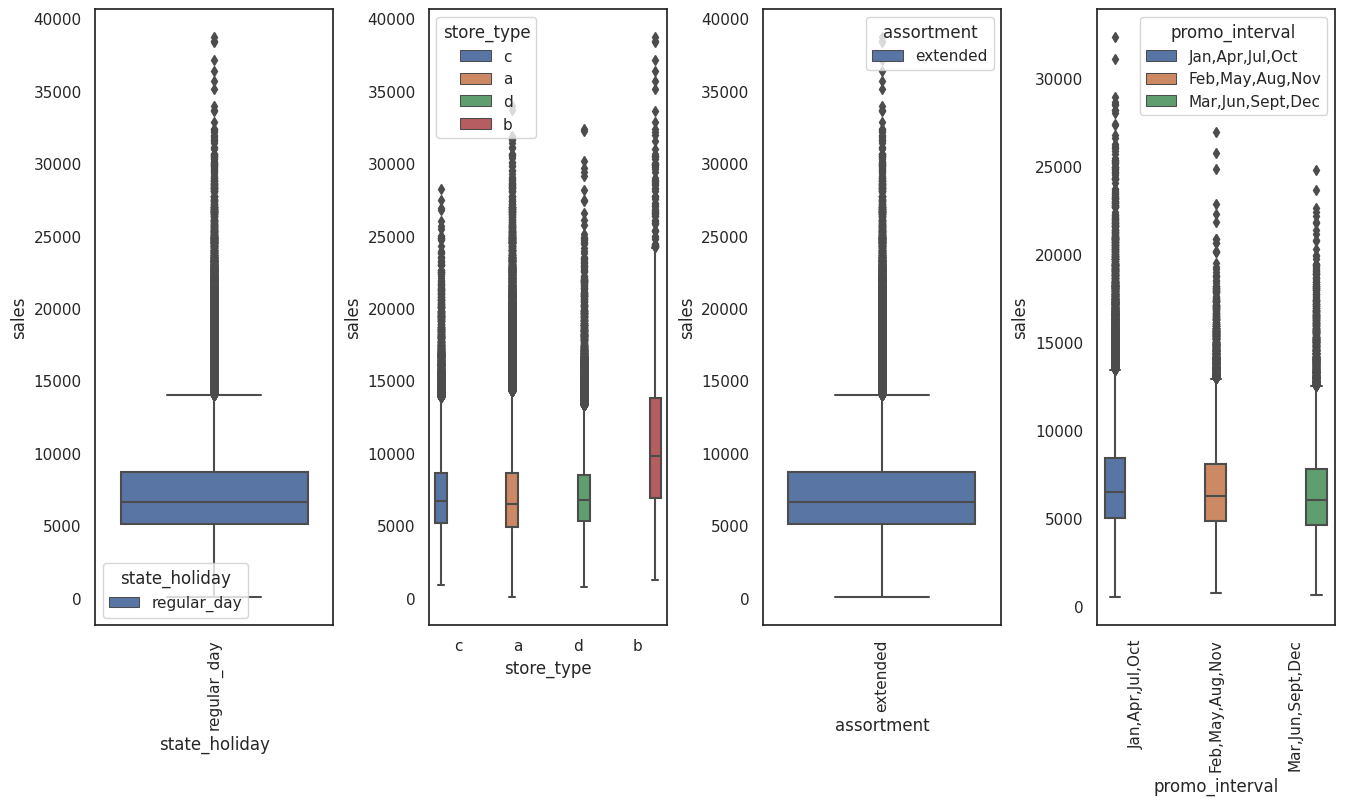

In [103]:
plt.figure(figsize=(16,8))

plt.subplot( 1, 4, 1 )
sns.set_style(style='white')
sns.boxplot( x='state_holiday', y='sales', data=X_val, hue = 'state_holiday' )
plt.xticks( rotation = 90)


plt.subplot( 1, 4, 2 )
sns.boxplot( x='store_type', y='sales', data=X_val, hue = 'store_type' )
sns.set_style(style='white')

plt.subplot( 1, 4, 3 )
sns.boxplot( x='assortment', y='sales', data=X_val, hue = 'assortment' )
sns.set_style(style='white')
plt.xticks( rotation = 90)

plt.subplot( 1, 4, 4 )
sns.boxplot( x='promo_interval', y='sales', data=X_val, hue = 'promo_interval' )
sns.set_style(style='white')
plt.xticks( rotation = 90)

# Add space between plots
plt.subplots_adjust(wspace=0.4)

plt.show();

# 2.0. Exploratory Data Analysis

## 2.0.0. Generating Hypothesis

### 2.0.1. Hypothesis Mindmap

![Image]( ../img/mind_map_EN.png )

### 2.0.2. Hypothesis creation

**1.** Stores with a larger number of employees should sell more.

**2.** Stores with greater stock capacity should sell more.

**3.** Larger stores should sell more.

**4.** Stores with greater assortments should sell more.

**5.** Stores with closer competitors should sell less.

**6.** Stores with competitors for longer should sell more.

#### 2.0.2.2. Hypothesis about the products

**1.** Stores that invest more in Marketing should sell more.

**2.** Stores with greater product display should sell more.

**3.** Stores with lower priced products should sell more.

**5.** Stores with more aggressive promotions (bigger discounts) should sell more.

**6.** Stores with active promotions for longer should sell more.

**7.** Stores with more promotion days should sell more.

**8.** Stores with more consecutive promotions should sell more.

#### 2.0.2.3. Hypothesis about time

**1.** Stores open during the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

### 2.0.3. List of studying hypothesis

**1.** Stores with greater assortments should sell more.  

**2.** Stores with closer competitors should sell less.  

**3.** Stores with competitors for longer should sell more.  

**4.** Stores with active promotions for longer should sell more.  

**5.** Stores with more promotion days should sell more.  

**7.** Stores with more consecutive promotions should sell more.  

**8.** Stores open during the Christmas holiday should sell more.  

**9.** Stores should sell more over the years.  

**10.** Stores should sell more in the second half of the year.  

**11.** Stores should sell more after the 10th of each month.  

**12.** Stores should sell less on weekends.  

**13.** Stores should sell less during school holidays.  

## 2.1. Univariate Analysis

### 2.1.1. Response Variable

/home/thiago/.pyenv/versions/3.10.4/envs/ds_prod/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


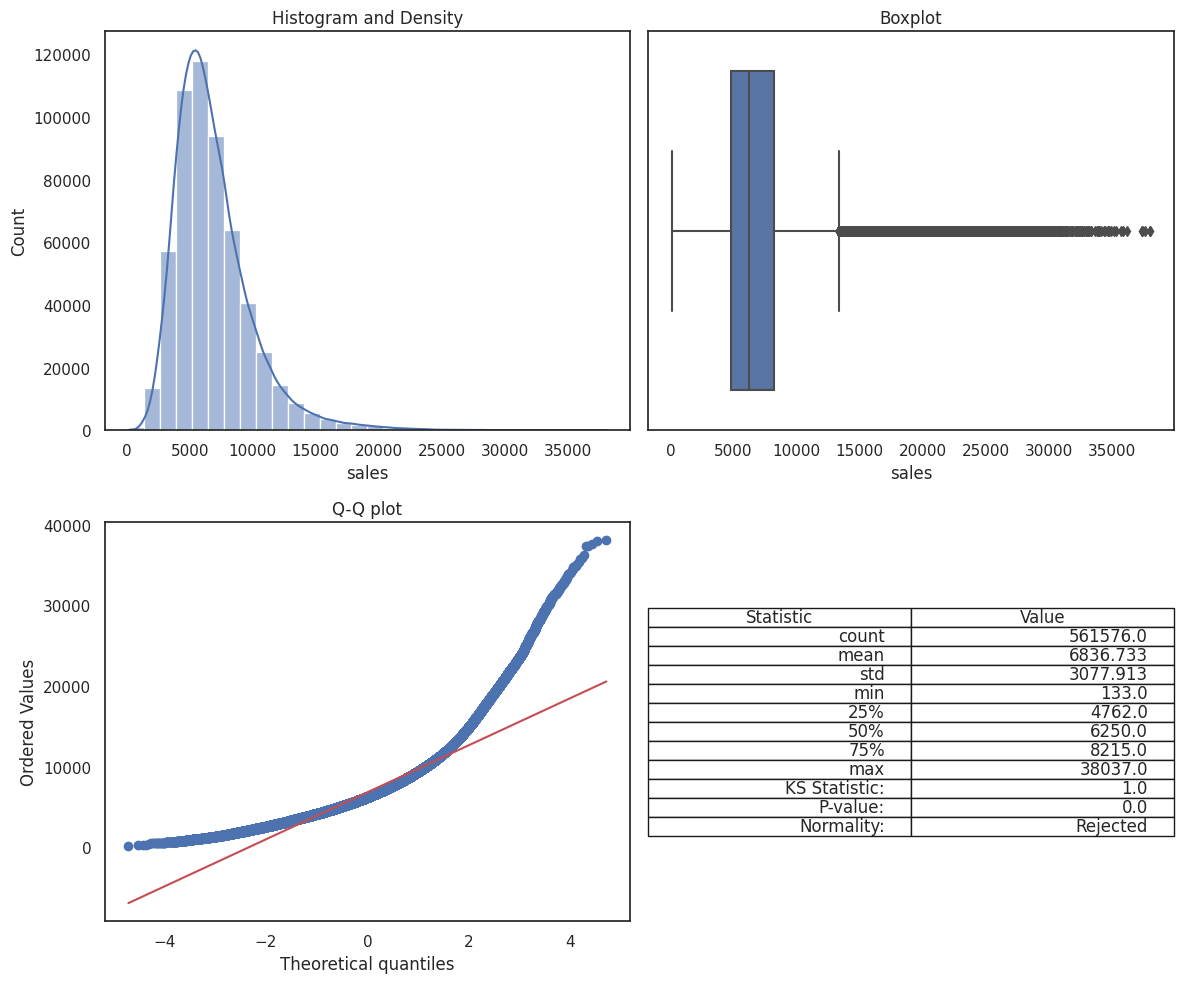

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Perform Kolmogorov-Smirnov test
# This compares the sample data to a normal distribution with mean 0 and standard deviation 1
ks_statistic, ks_p_value = stats.kstest(X_train["sales"], "norm")

# Check summary statistics of 'sales' column
sales_summary = X_train["sales"].describe().round(3)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot histogram and density
sns.histplot(X_train["sales"], bins=30, ax=axes[0, 0], kde=True)
axes[0, 0].set_title("Histogram and Density")

# Plot boxplot
sns.boxplot(x="sales", data=X_train, ax=axes[0, 1])
axes[0, 1].set_title("Boxplot")

# Plot Q-Q plot
stats.probplot(X_train["sales"], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title("Q-Q plot")

# Create table
table_data = sales_summary.to_frame().reset_index().values
table_data = [[str(entry) for entry in row] for row in table_data]
table_data.append(["KS Statistic:", str(ks_statistic)])
table_data.append(["P-value:", str(ks_p_value)])
if ks_p_value < 0.05:
    table_data.append(["Normality:", "Rejected"])
else:
    table_data.append(["Normality:", "Not rejected"])

axes[1, 1].axis("off")  # Hide axis for the table
axes[1, 1].table(cellText=table_data, loc="center", colLabels=["Statistic", "Value"])

plt.tight_layout()
plt.show()

/home/thiago/.pyenv/versions/3.10.4/envs/ds_prod/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_96653/3227112690.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["log_sales"] = np.log10(X_train["sales"])


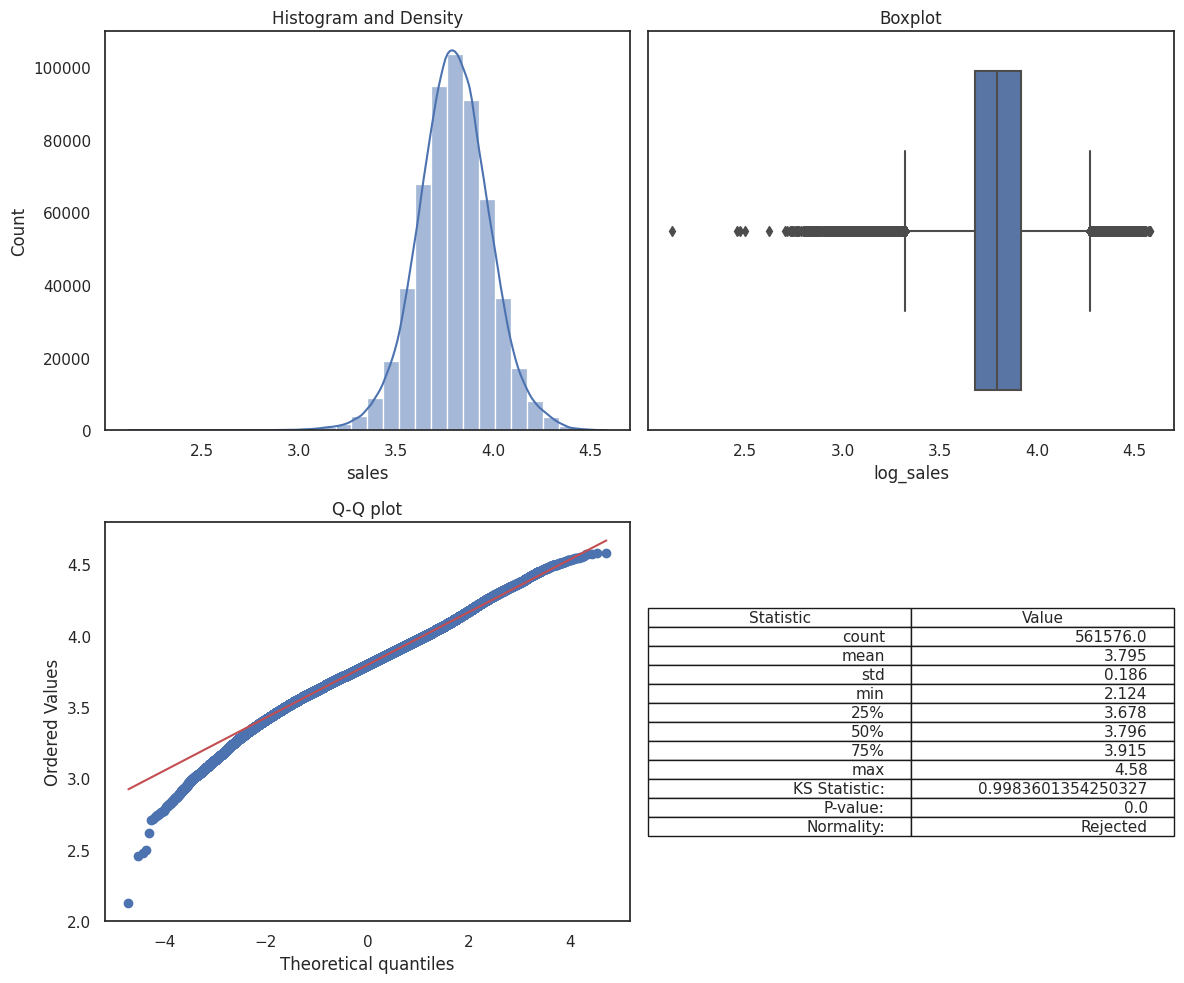

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Perform Kolmogorov-Smirnov test
# This compares the sample data to a normal distribution with mean 0 and standard deviation 1
ks_statistic, ks_p_value = stats.kstest(np.log10(X_train["sales"]), "norm")

# Check summary statistics of 'sales' column
sales_summary = np.log10(X_train["sales"]).describe().round(3)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot histogram and density
sns.histplot(np.log10(X_train["sales"]), bins=30, ax=axes[0, 0], kde=True)
axes[0, 0].set_title("Histogram and Density")

# Plot boxplot
X_train["log_sales"] = np.log10(X_train["sales"])

sns.boxplot(x="log_sales", data=X_train, ax=axes[0, 1])
axes[0, 1].set_title("Boxplot")

# Plot Q-Q plot
stats.probplot(np.log10(X_train["sales"]), dist="norm", plot=axes[1, 0])
axes[1, 0].set_title("Q-Q plot")

# Create table
table_data = sales_summary.to_frame().reset_index().values
table_data = [[str(entry) for entry in row] for row in table_data]
table_data.append(["KS Statistic:", str(ks_statistic)])
table_data.append(["P-value:", str(ks_p_value)])
if ks_p_value < 0.05:
    table_data.append(["Normality:", "Rejected"])
else:
    table_data.append(["Normality:", "Not rejected"])

axes[1, 1].axis("off")  # Hide axis for the table
axes[1, 1].table(cellText=table_data, loc="center", colLabels=["Statistic", "Value"])

plt.tight_layout()
plt.show()

In [ ]:
X_train = X_train.drop(['log_sales'], axis=1)

Index(['store', 'day_of_week', 'date', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'sales'],
      dtype='object')

#### 2.1.2.0. Separate Numerical and Categorical data

In [107]:
num_attributes = X_train.select_dtypes( include=['int64', 'float64'] )
cat_attributes = X_train.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 2.1.2. Numerical Variables

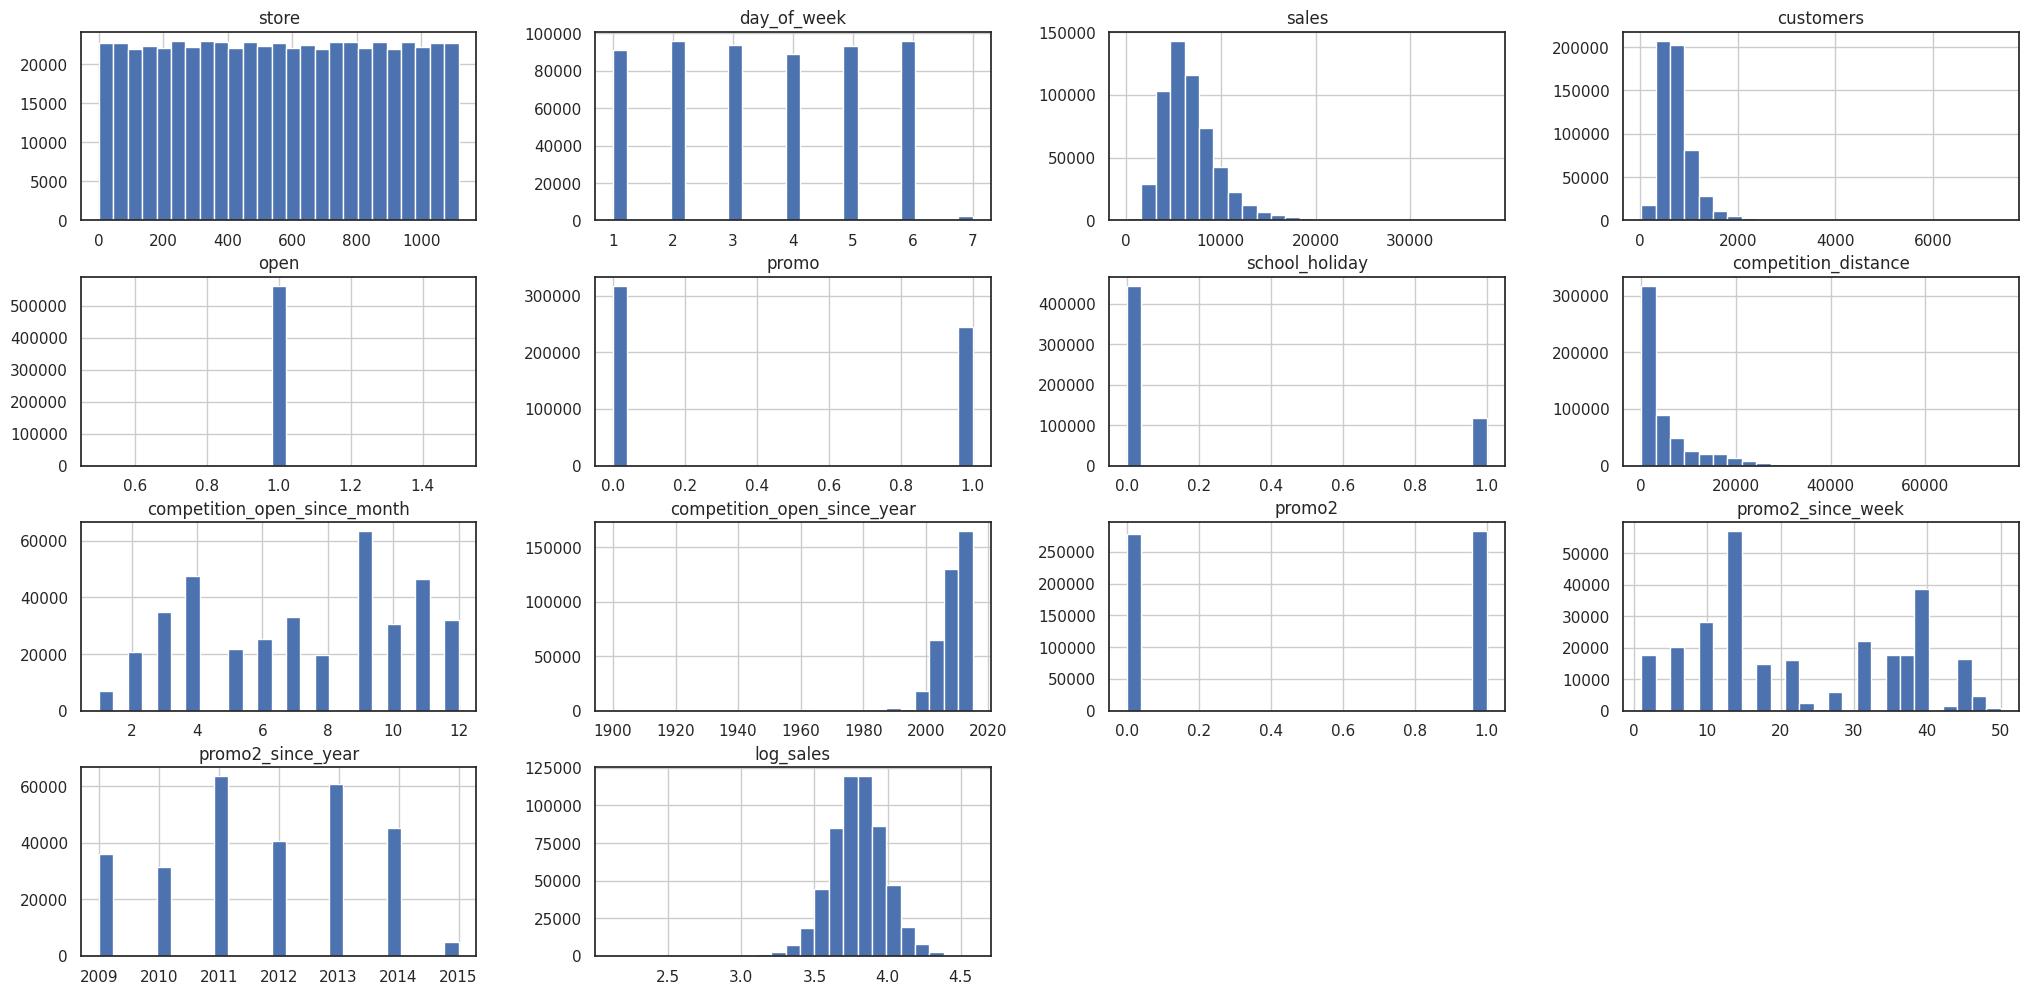

In [108]:
num_attributes.hist( bins=25 );
sns.set_style(style='white')

### 2.1.3. Categorical Variables

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/thiago/.pyenv/versions/3.10.4/envs/ds_prod/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/thiago/.pyenv/versions/3.10.4/envs/ds_prod/lib/python3.10/site-pa

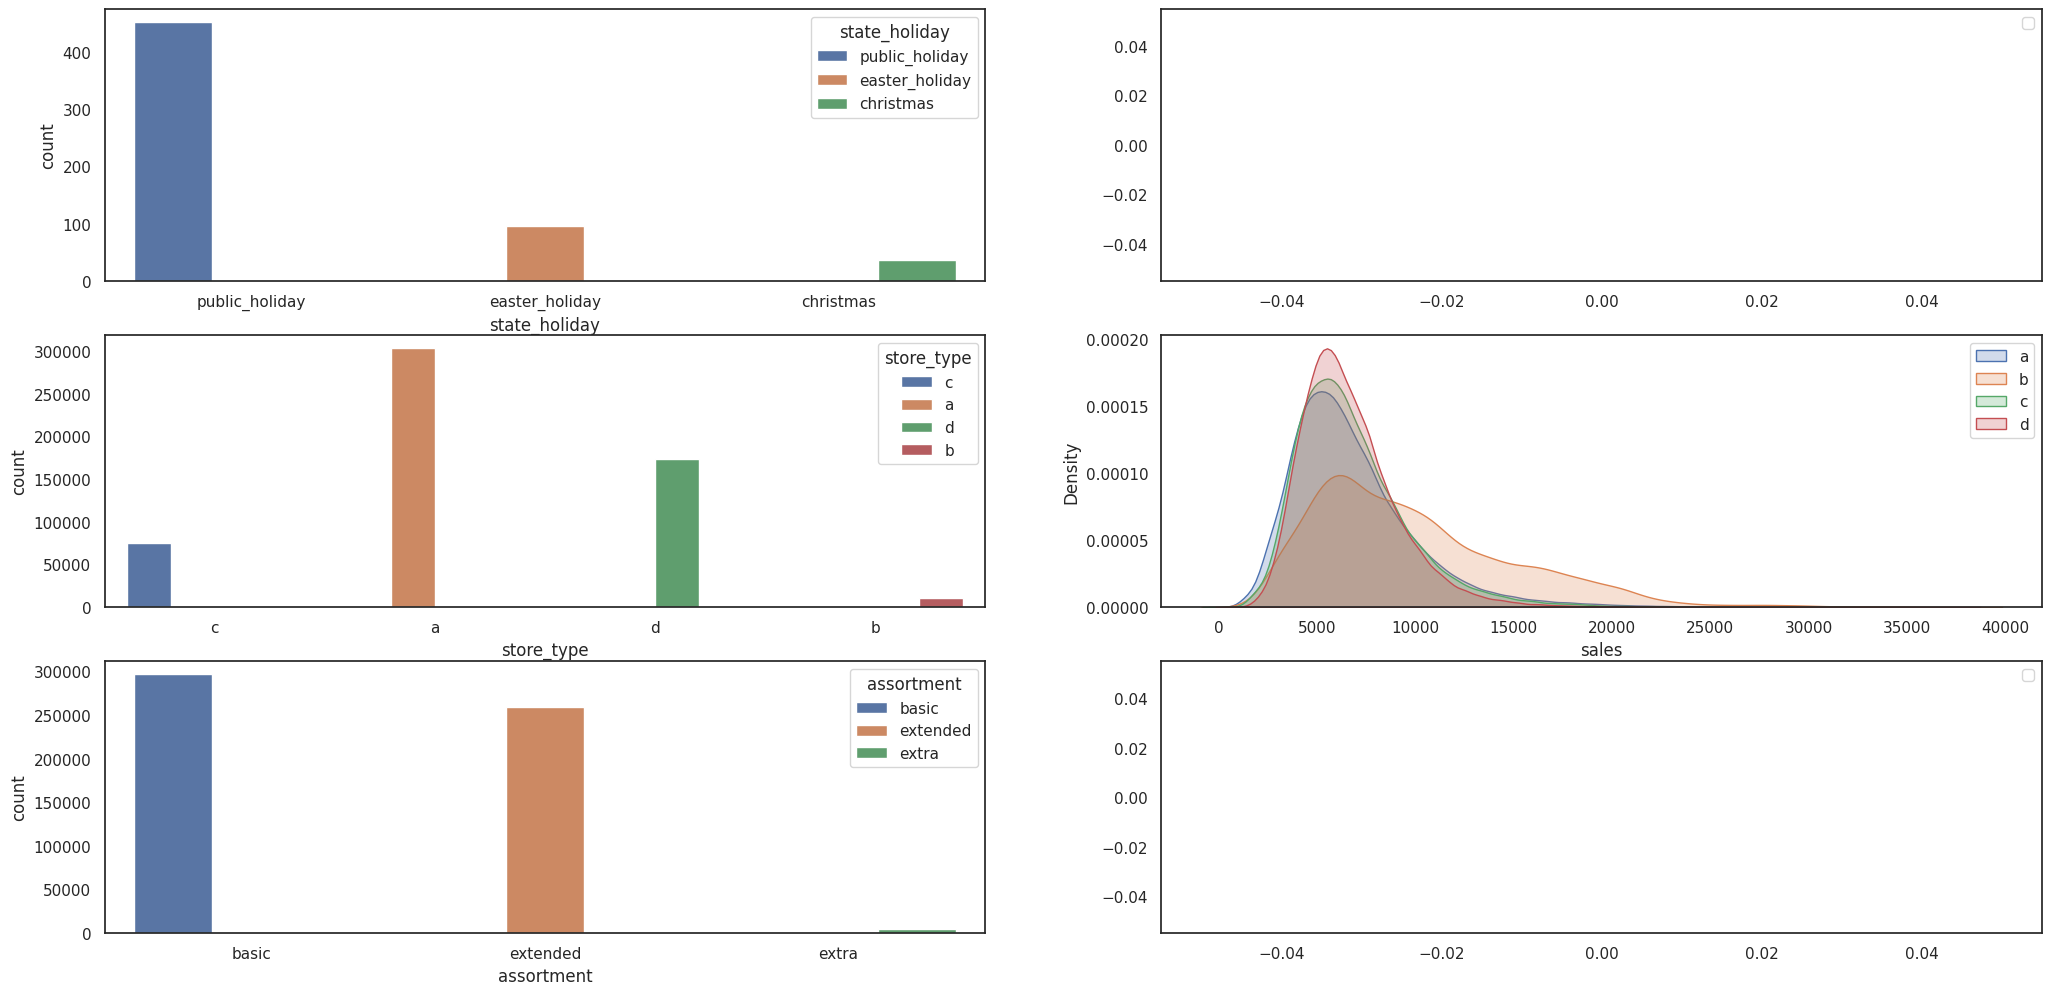

In [109]:
sns.set_style(style='white')

# state_holiday
plt.subplot( 3, 2, 1 )
# X_train = X_train[X_train['state_holiday'] != 'regular_day']
sns.countplot( x='state_holiday', data=X_train[X_train['state_holiday'] != 'regular_day'], hue = 'state_holiday')


plt.subplot( 3, 2, 2 )
sns.kdeplot( X_train[X_train['state_holiday'] == 'd']['sales'], label='regular_day', fill=True ).legend(loc="upper right")
sns.kdeplot( X_train[X_train['state_holiday'] == 'a']['sales'], label='public_holiday', fill=True ).legend(loc="upper right")
sns.kdeplot( X_train[X_train['state_holiday'] == 'b']['sales'], label='easter_holiday', fill=True ).legend(loc="upper right")
sns.kdeplot( X_train[X_train['state_holiday'] == 'c']['sales'], label='christmas', fill=True ).legend(loc="upper right")
plt.ticklabel_format(style='plain', axis='y')

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( x='store_type', data=X_train, hue = 'store_type' )

plt.subplot( 3, 2, 4 )
sns.kdeplot( X_train[X_train['store_type'] == 'a']['sales'], label='a', fill=True ).legend(loc="upper right")
sns.kdeplot( X_train[X_train['store_type'] == 'b']['sales'], label='b', fill=True ).legend(loc="upper right")
sns.kdeplot( X_train[X_train['store_type'] == 'c']['sales'], label='c', fill=True ).legend(loc="upper right")
sns.kdeplot( X_train[X_train['store_type'] == 'd']['sales'], label='d', fill=True ).legend(loc="upper right")

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( data=X_train, x='assortment', hue = 'assortment' )

plt.subplot( 3, 2, 6 )
sns.kdeplot( X_train[X_train['assortment'] == 'c']['sales'], label='extended', fill=True ).legend(loc="upper right")
sns.kdeplot( X_train[X_train['assortment'] == 'a']['sales'], label='basic', fill=True ).legend(loc="upper right")
sns.kdeplot( X_train[X_train['assortment'] == 'b']['sales'], label='extra', fill=True ).legend(loc="upper right")

In [77]:
X_train[['customers','store_type']].groupby(['store_type']).mean().reset_index().round(2)

store_type  customers
0          a     659.73
1          b    1942.09
2          c     670.57
3          d     496.66

In [43]:
X_train[['customers','assortment']].groupby(['assortment']).mean().reset_index().round(2)

assortment  customers
0          a     748.50
1          b    1994.74
2          c     745.47

In [89]:
X_train[['customers','store_type','assortment']].groupby(['store_type','assortment']).mean().reset_index().round(2)

store_type assortment  customers
0          a          a     761.22
1          a          c     853.25
2          b          a    1826.66
3          b          b    1994.74
4          b          c    3103.59
5          c          a     840.82
6          c          c     780.46
7          d          a     582.73
8          d          c     610.10

In [44]:
X_train[['sales','store_type']].groupby(['store_type']).mean().reset_index().round(2)

store_type    sales
0          a  6838.07
1          b  9927.24
2          c  6808.40
3          d  6665.22

In [45]:
X_train[['sales','assortment']].groupby(['assortment']).mean().reset_index().round(2)

assortment    sales
0          a  6554.68
1          b  8150.58
2          c  7131.91

In [90]:
X_train[['sales','store_type','assortment']].groupby(['store_type','assortment']).mean().reset_index().round(2)

store_type assortment     sales
0          a          a   6482.52
1          a          c   7437.93
2          b          a  11068.87
3          b          b   8150.58
4          b          c  17816.19
5          c          a   6757.19
6          c          c   6863.79
7          d          a   6352.04
8          d          c   6845.10

In [53]:
print(f'Proportion (%) of {X_train["store_type"].value_counts(normalize=True).round(2)*100}')

Proportion (%) of store_type
a    54.0
d    31.0
c    13.0
b     2.0
Name: proportion, dtype: float64


In [54]:
print(f'Proportion (%) of {X_train["assortment"].value_counts(normalize=True).round(2)*100}')

Proportion (%) of assortment
a    53.0
c    46.0
b     1.0
Name: proportion, dtype: float64


Verificar lojas com menor quantidade: store type, assortment

## 2.2. Bivariate Analysis

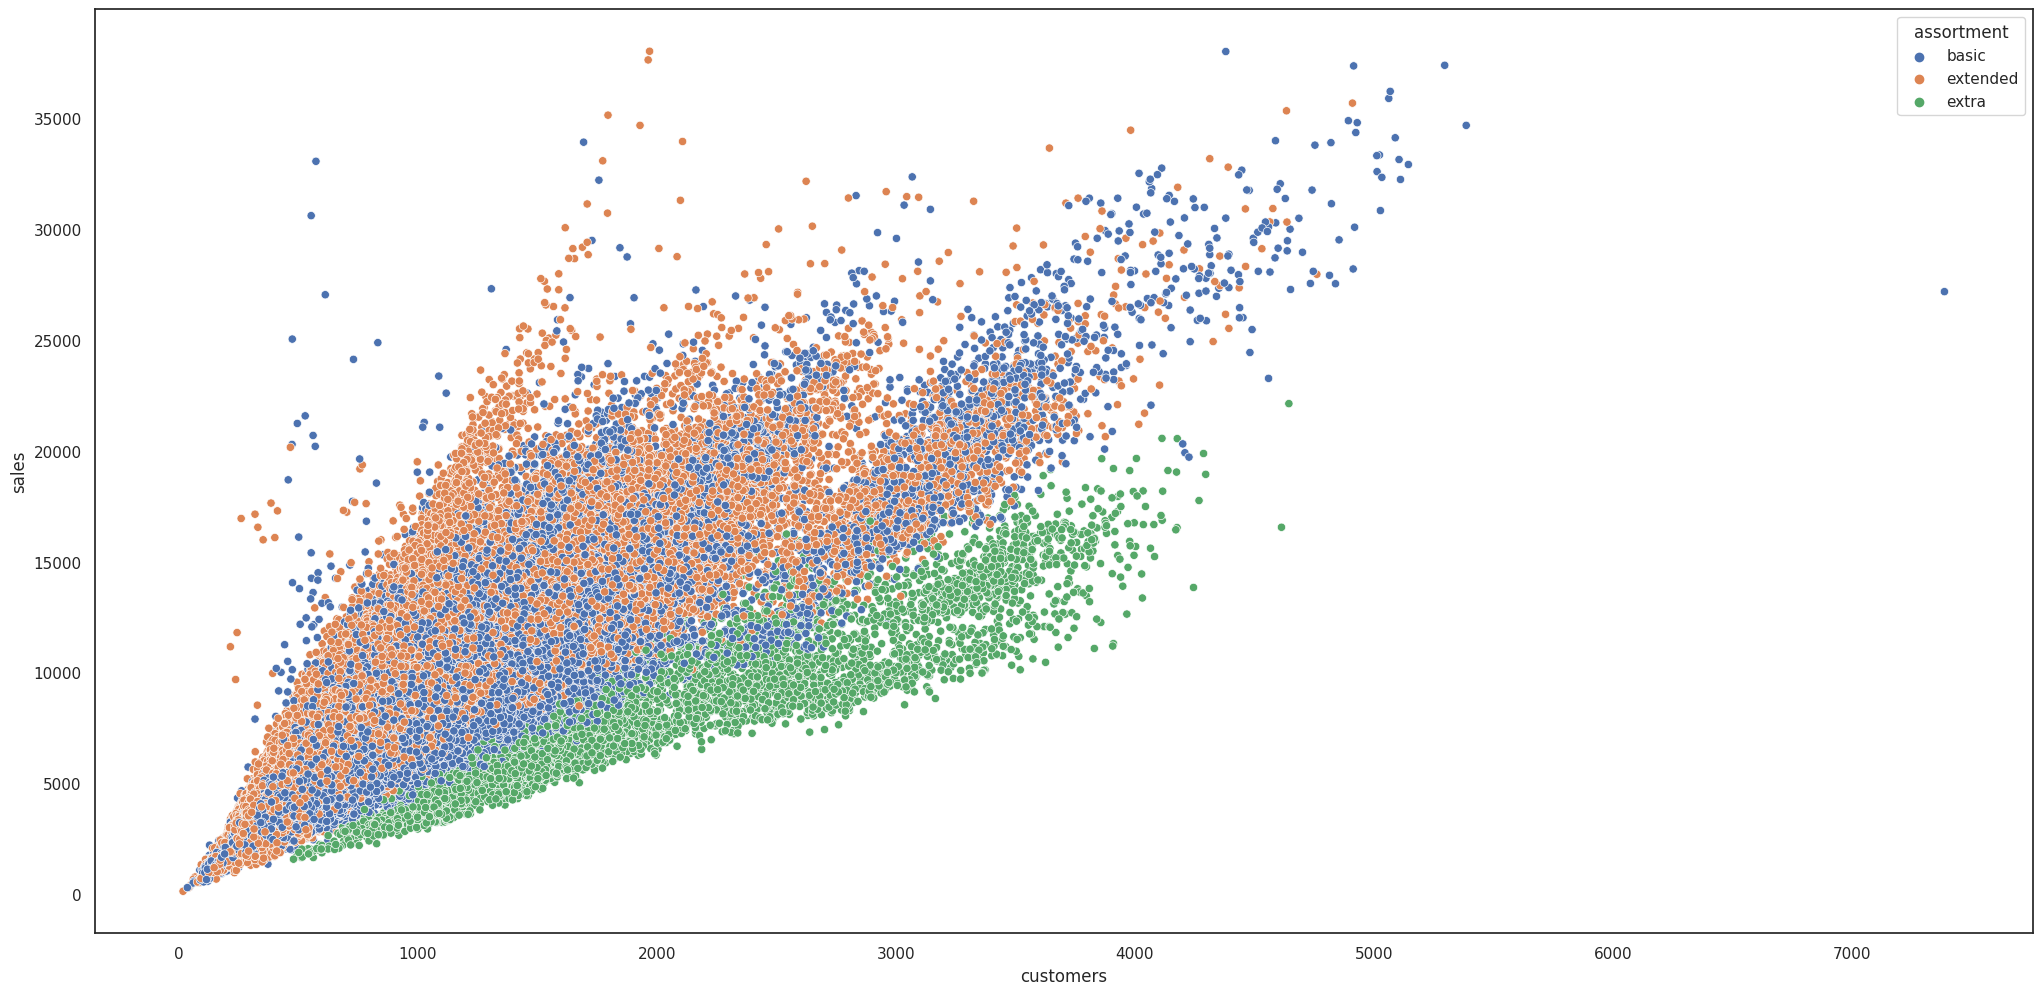

In [110]:
sns.scatterplot(x=X_train['customers'], y=X_train['sales'], hue=X_train['assortment']);

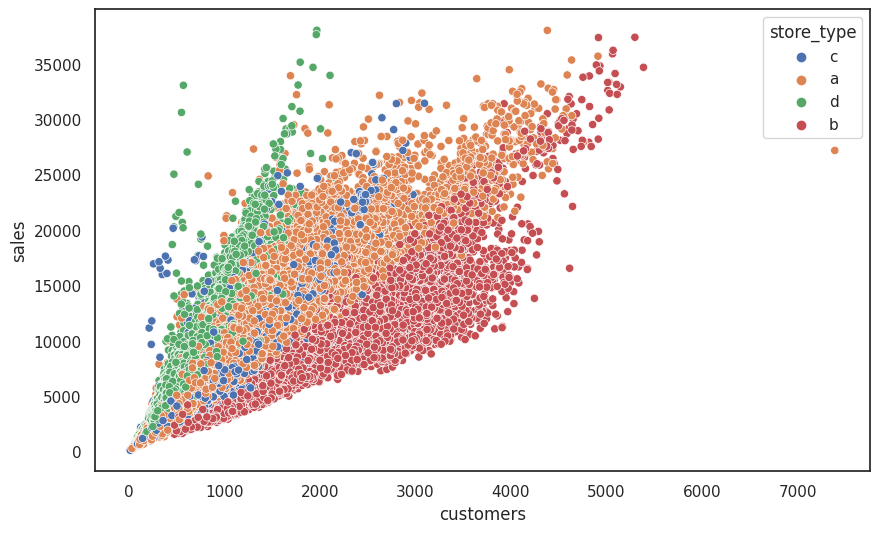

In [112]:
plt.figure(figsize=(10, 6))
sns.set_style(style='white')

sns.scatterplot(x=X_train['customers'], y=X_train['sales'], hue=X_train['store_type']);

### **H1.** Stores with more assortment should sell more.
**TRUE** Stores with MORE ASSORTMENT DO SELL MORE.

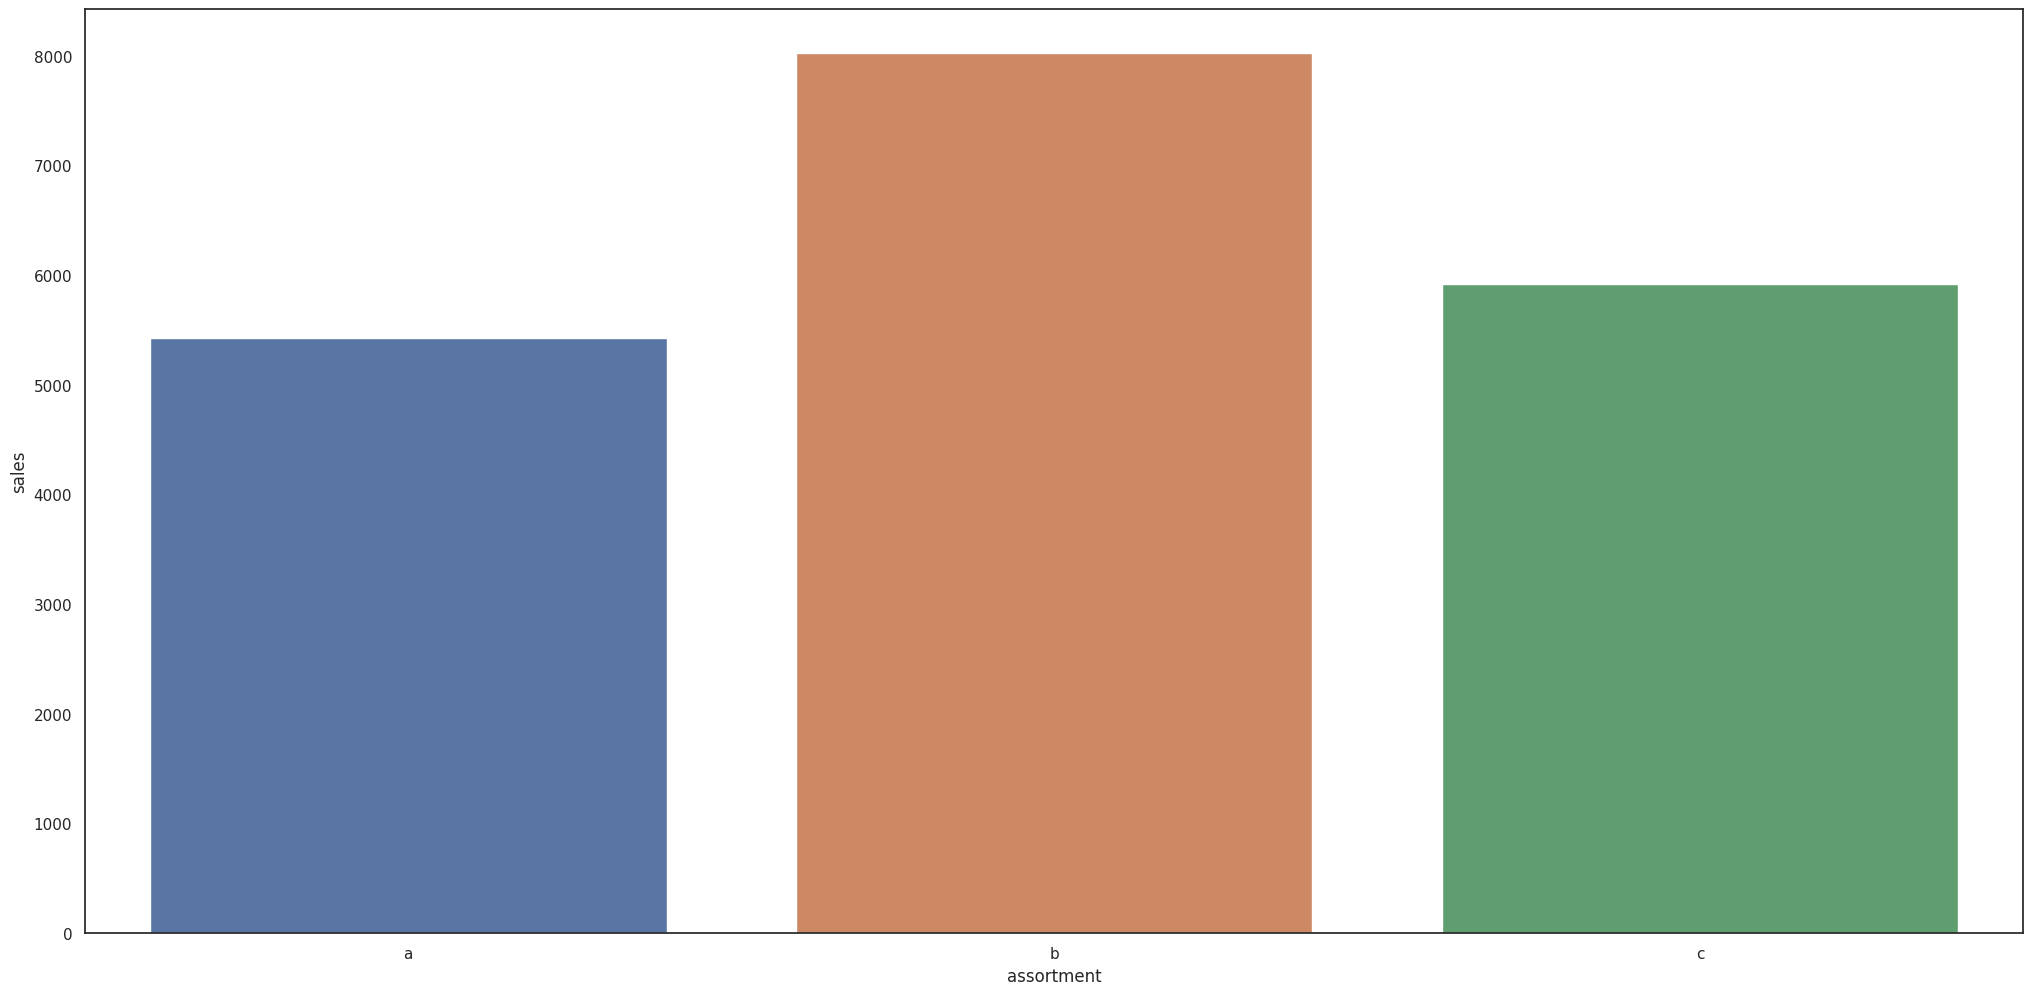

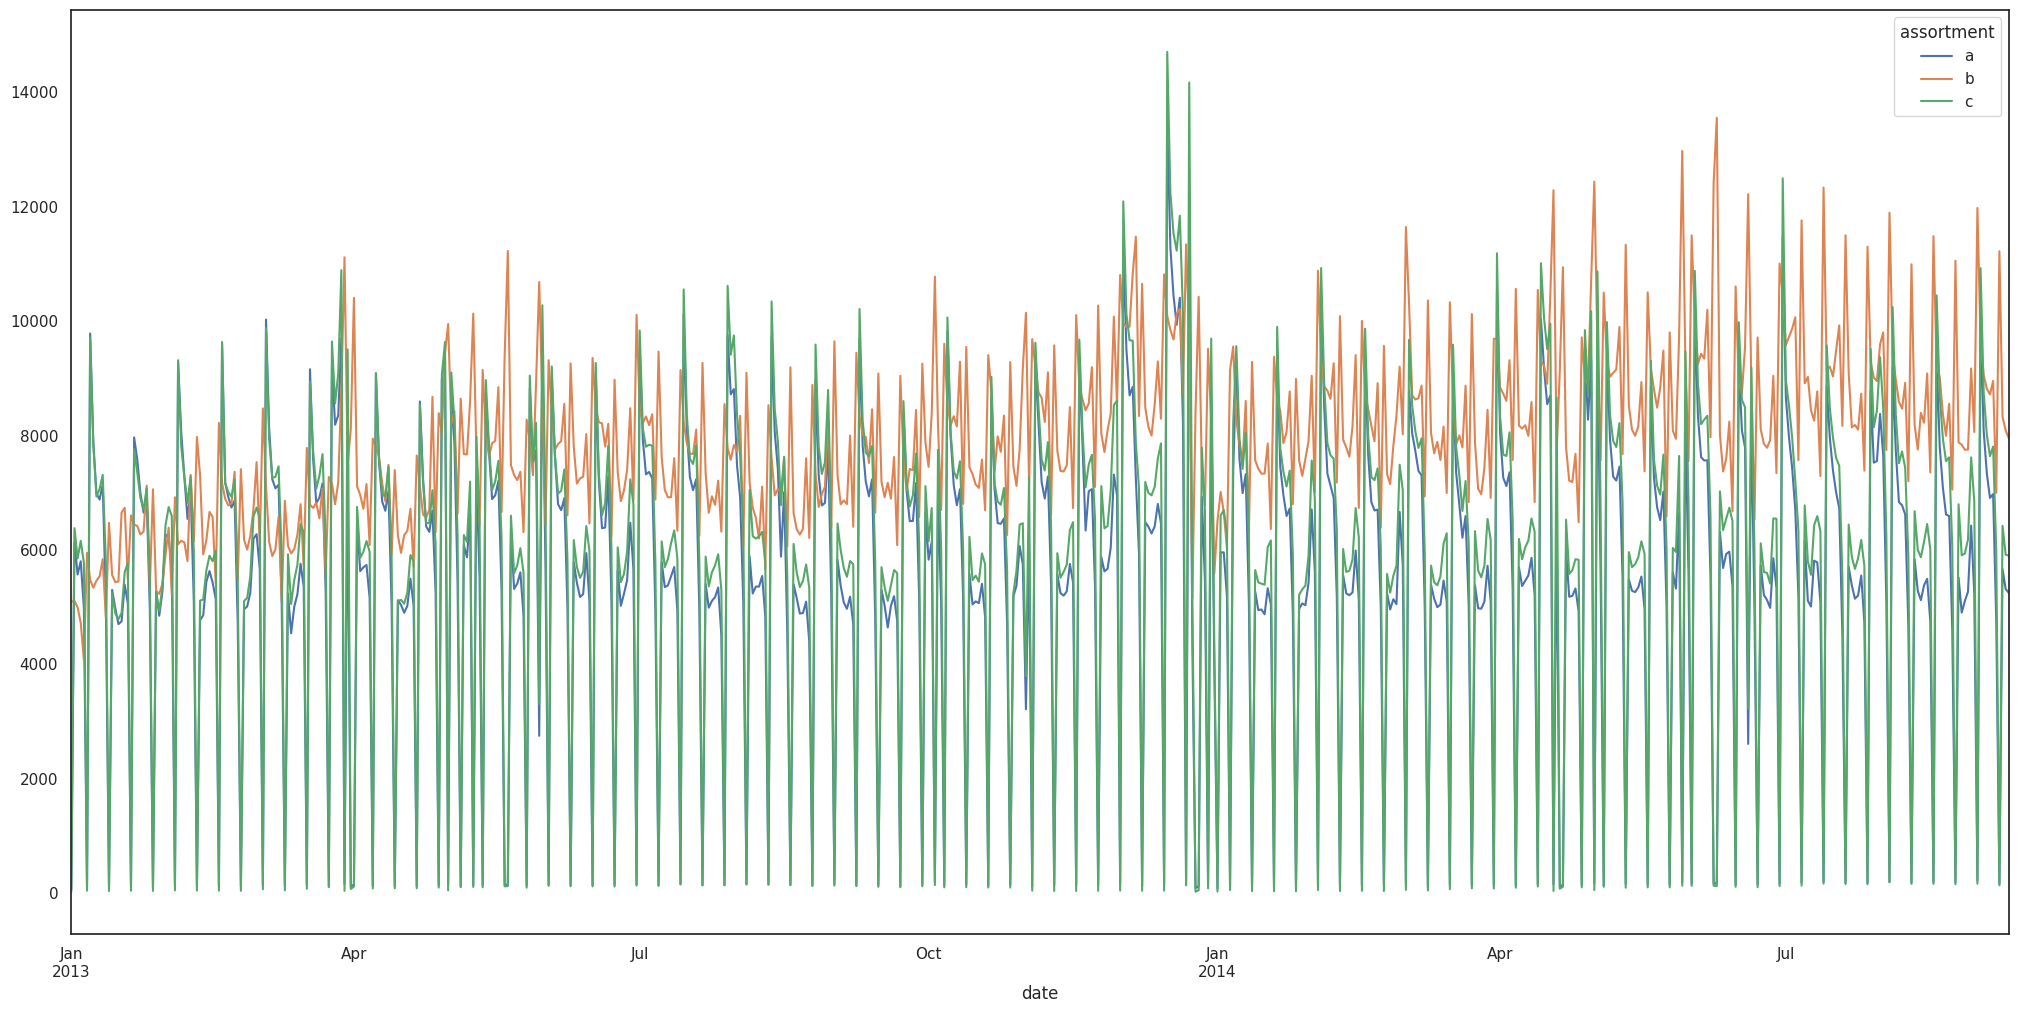

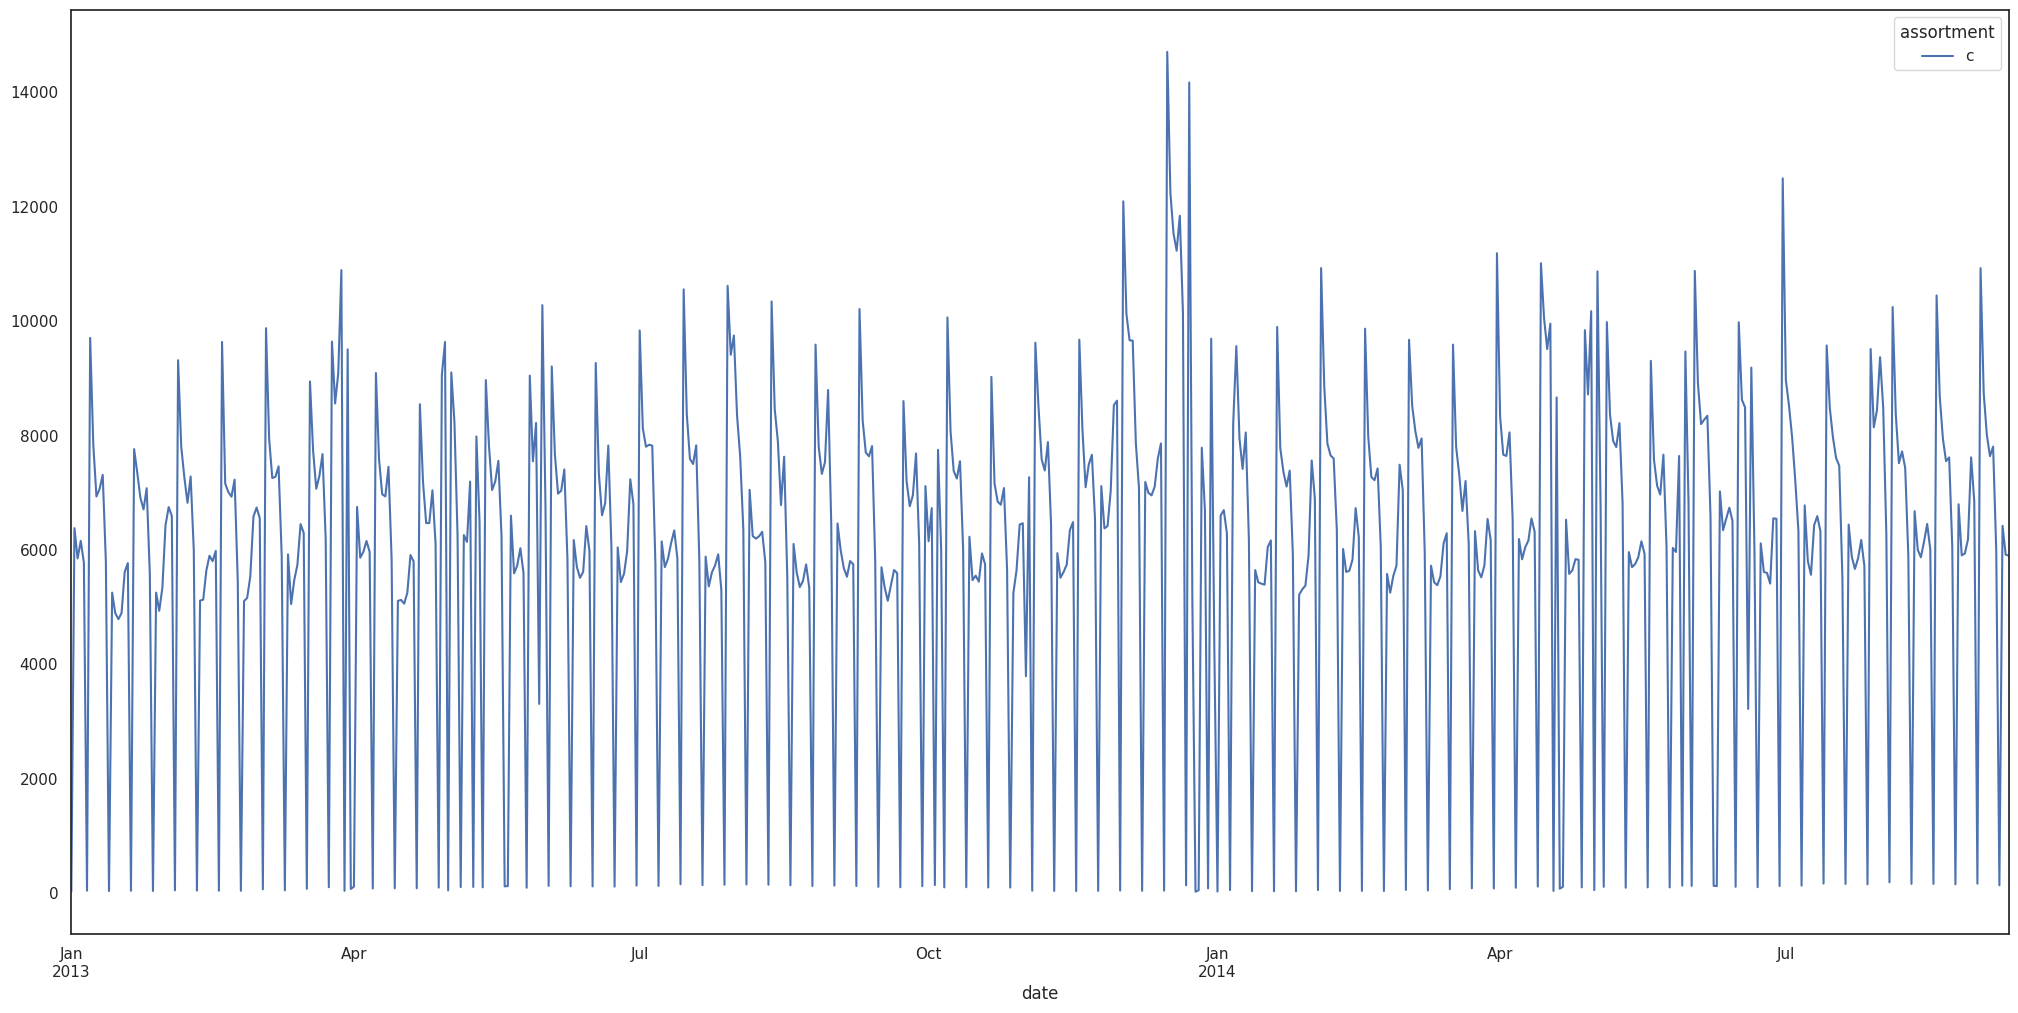

In [24]:
aux1 = X_train[['assortment', 'sales']].groupby( 'assortment' ).mean().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1, hue = 'assortment' );
plt.ticklabel_format(style='plain', axis='y')

aux2 = X_train[['date', 'assortment', 'sales']].groupby( ['date','assortment'] ).mean().reset_index()
aux2.pivot( index='date', columns='assortment', values='sales' ).plot();
plt.ticklabel_format(style='plain', axis='y')

aux3 = aux2[aux2['assortment'] == 'c']
aux3.pivot( index='date', columns='assortment', values='sales' ).plot();
plt.ticklabel_format(style='plain', axis='y')

### **H2.** Stores with closer competition should sell less.
**FALSE** Stores with close competition sell MORE.

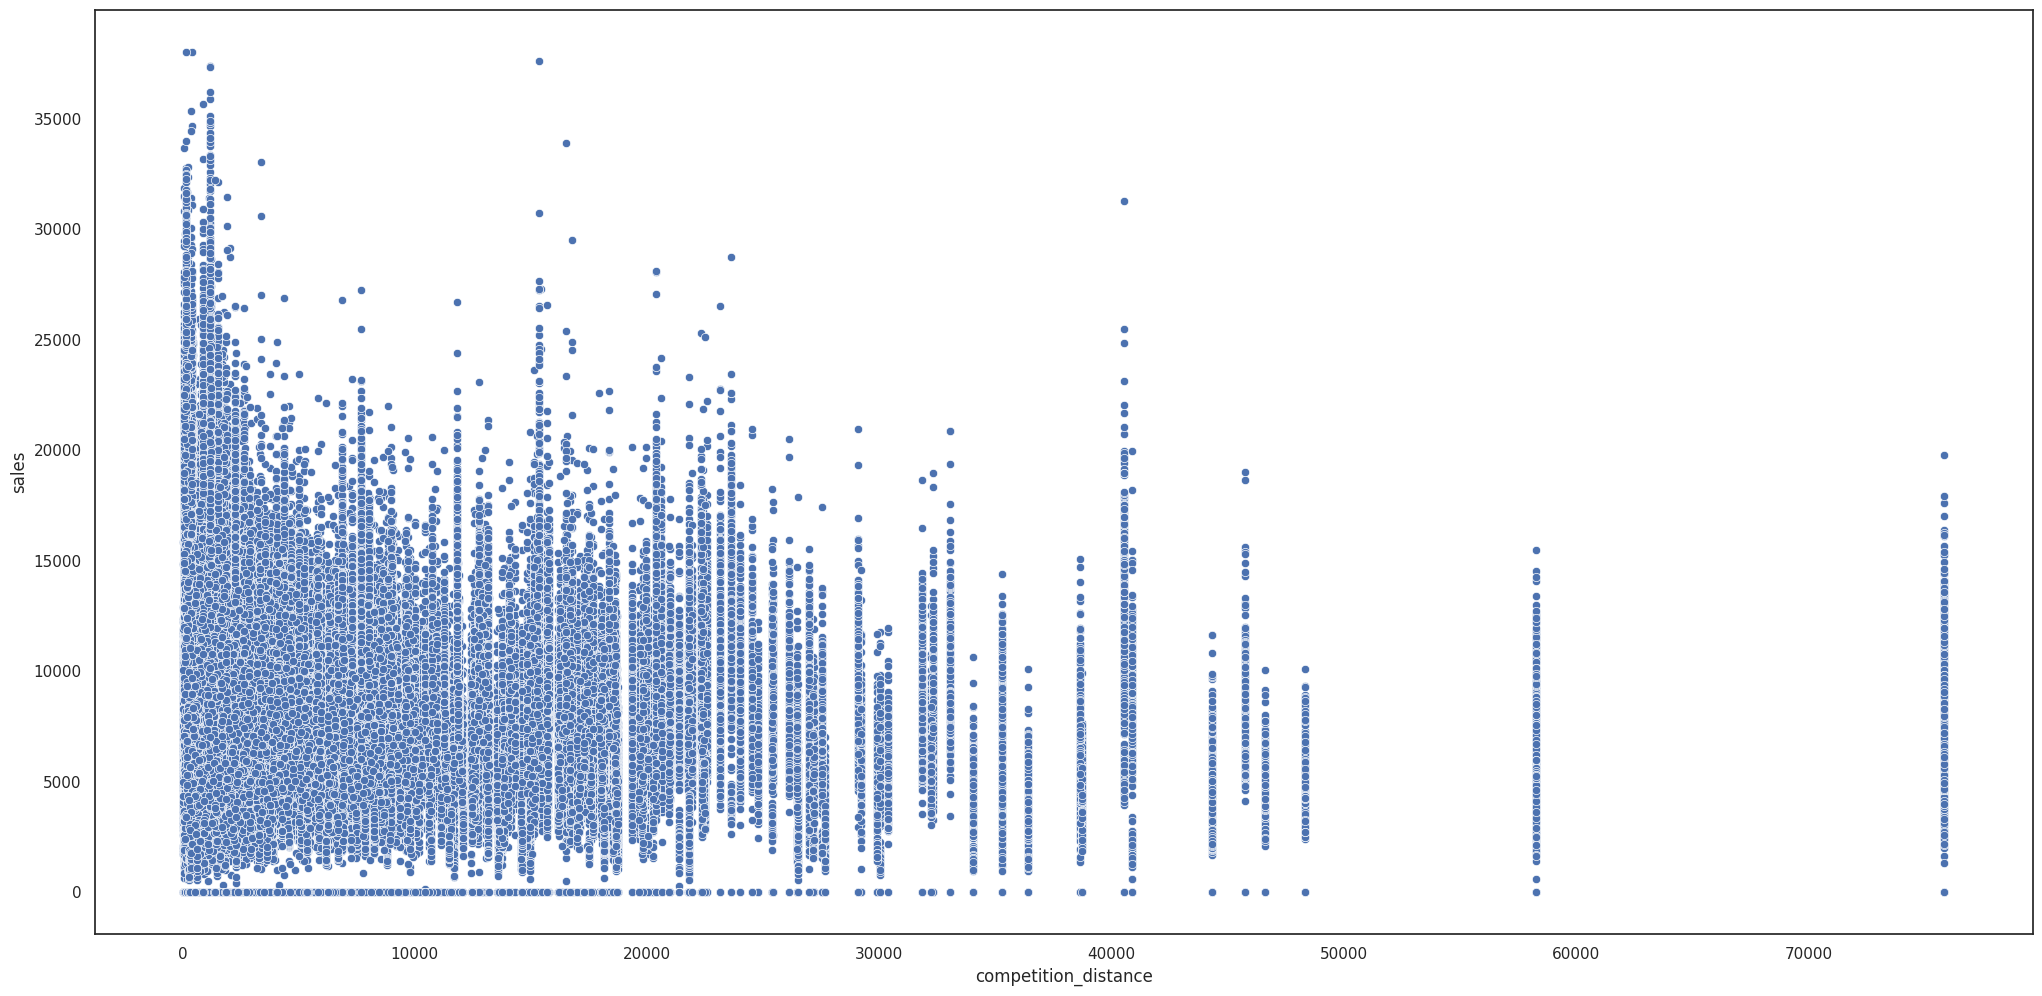

In [25]:
sns.scatterplot( x ='competition_distance', y='sales', data=X_train );

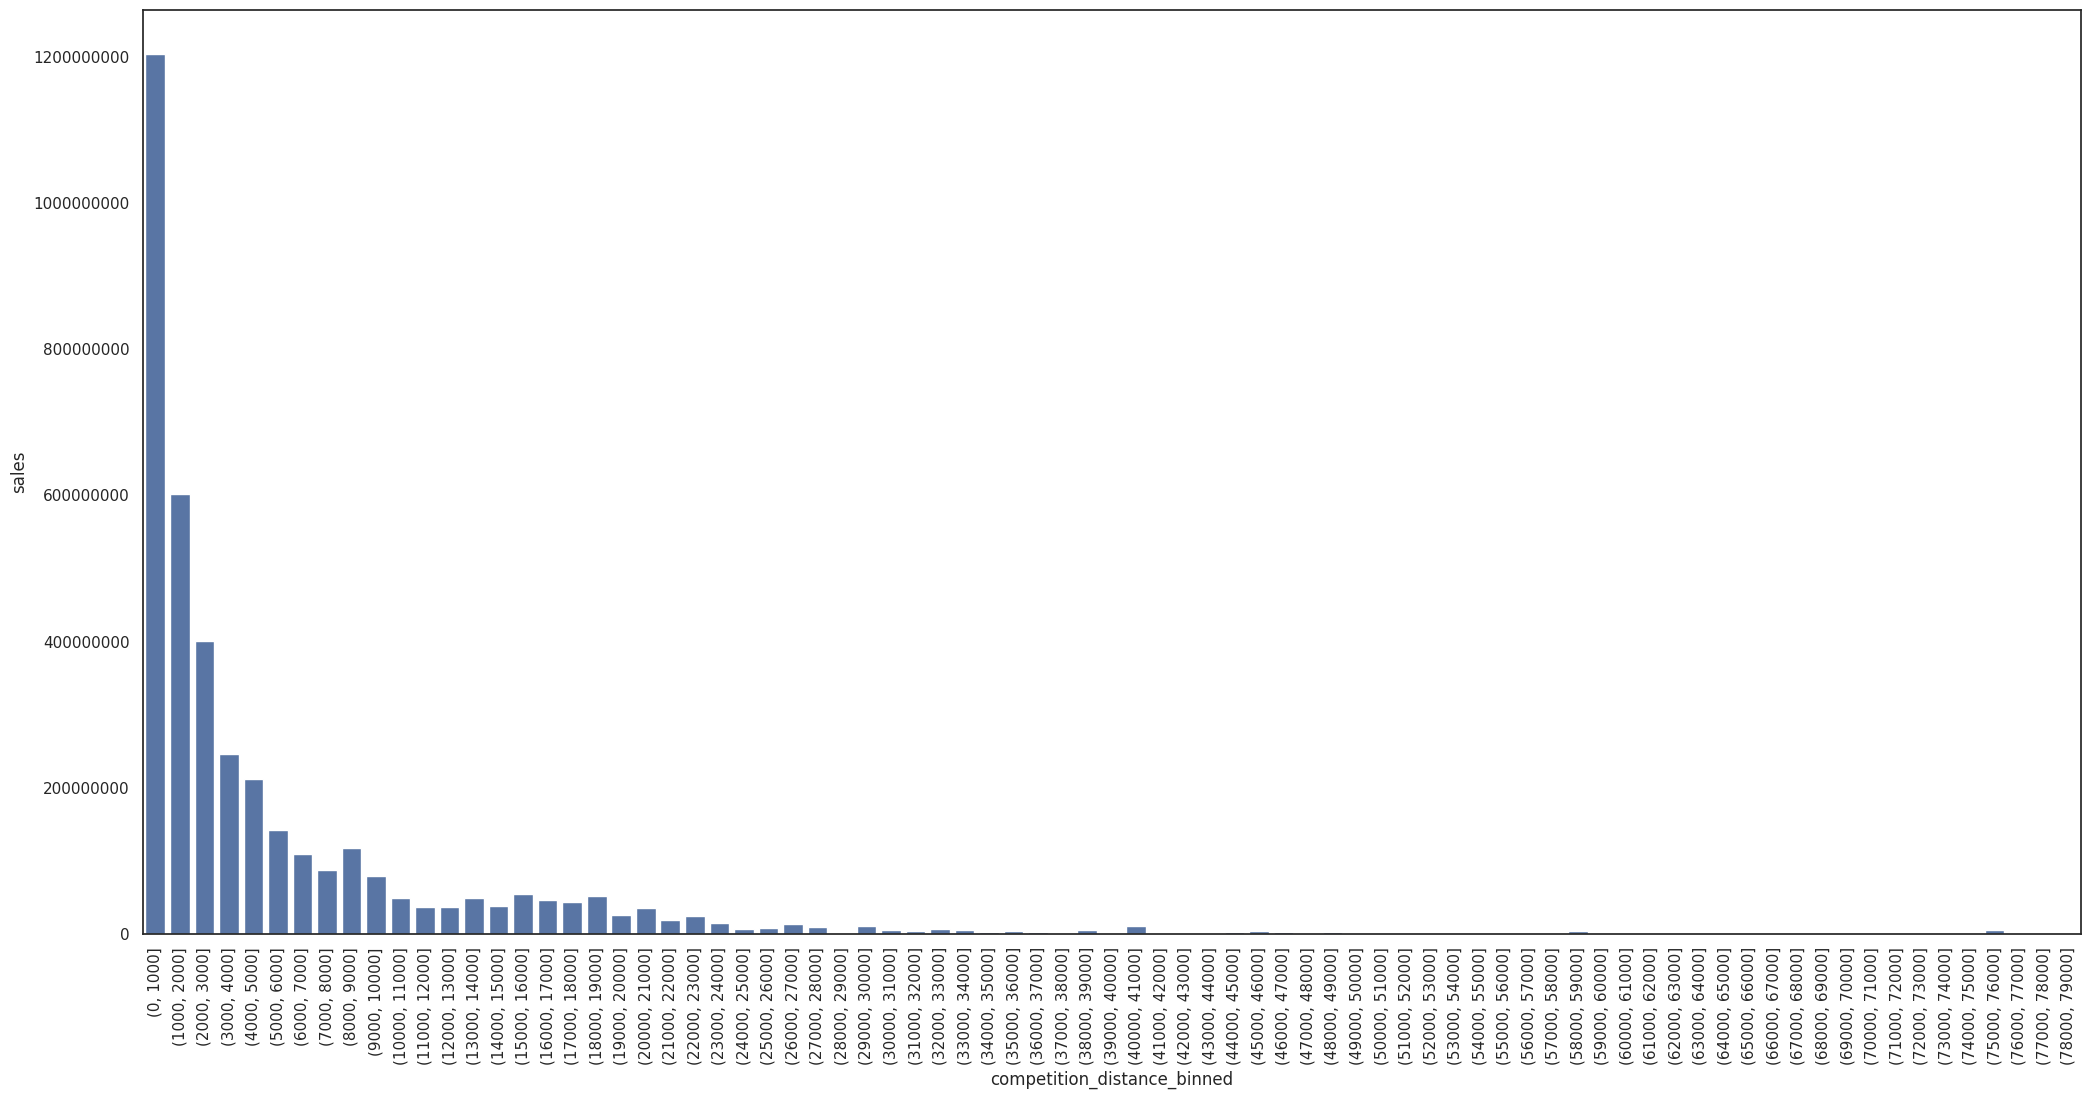

In [29]:
bins = list( np.arange( 0, 80000, 1000) )
X_train.loc[:,'competition_distance_binned'] = pd.cut( X_train['competition_distance'], bins=bins )
aux2 = X_train[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned', observed=False ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );
plt.ticklabel_format(style='plain', axis='y');

### **H3.** Stores with competition for a longer time should sell more.
**INCONCLUSIVE** 

<Axes: xlabel='competition_open_since_year', ylabel='sales'>

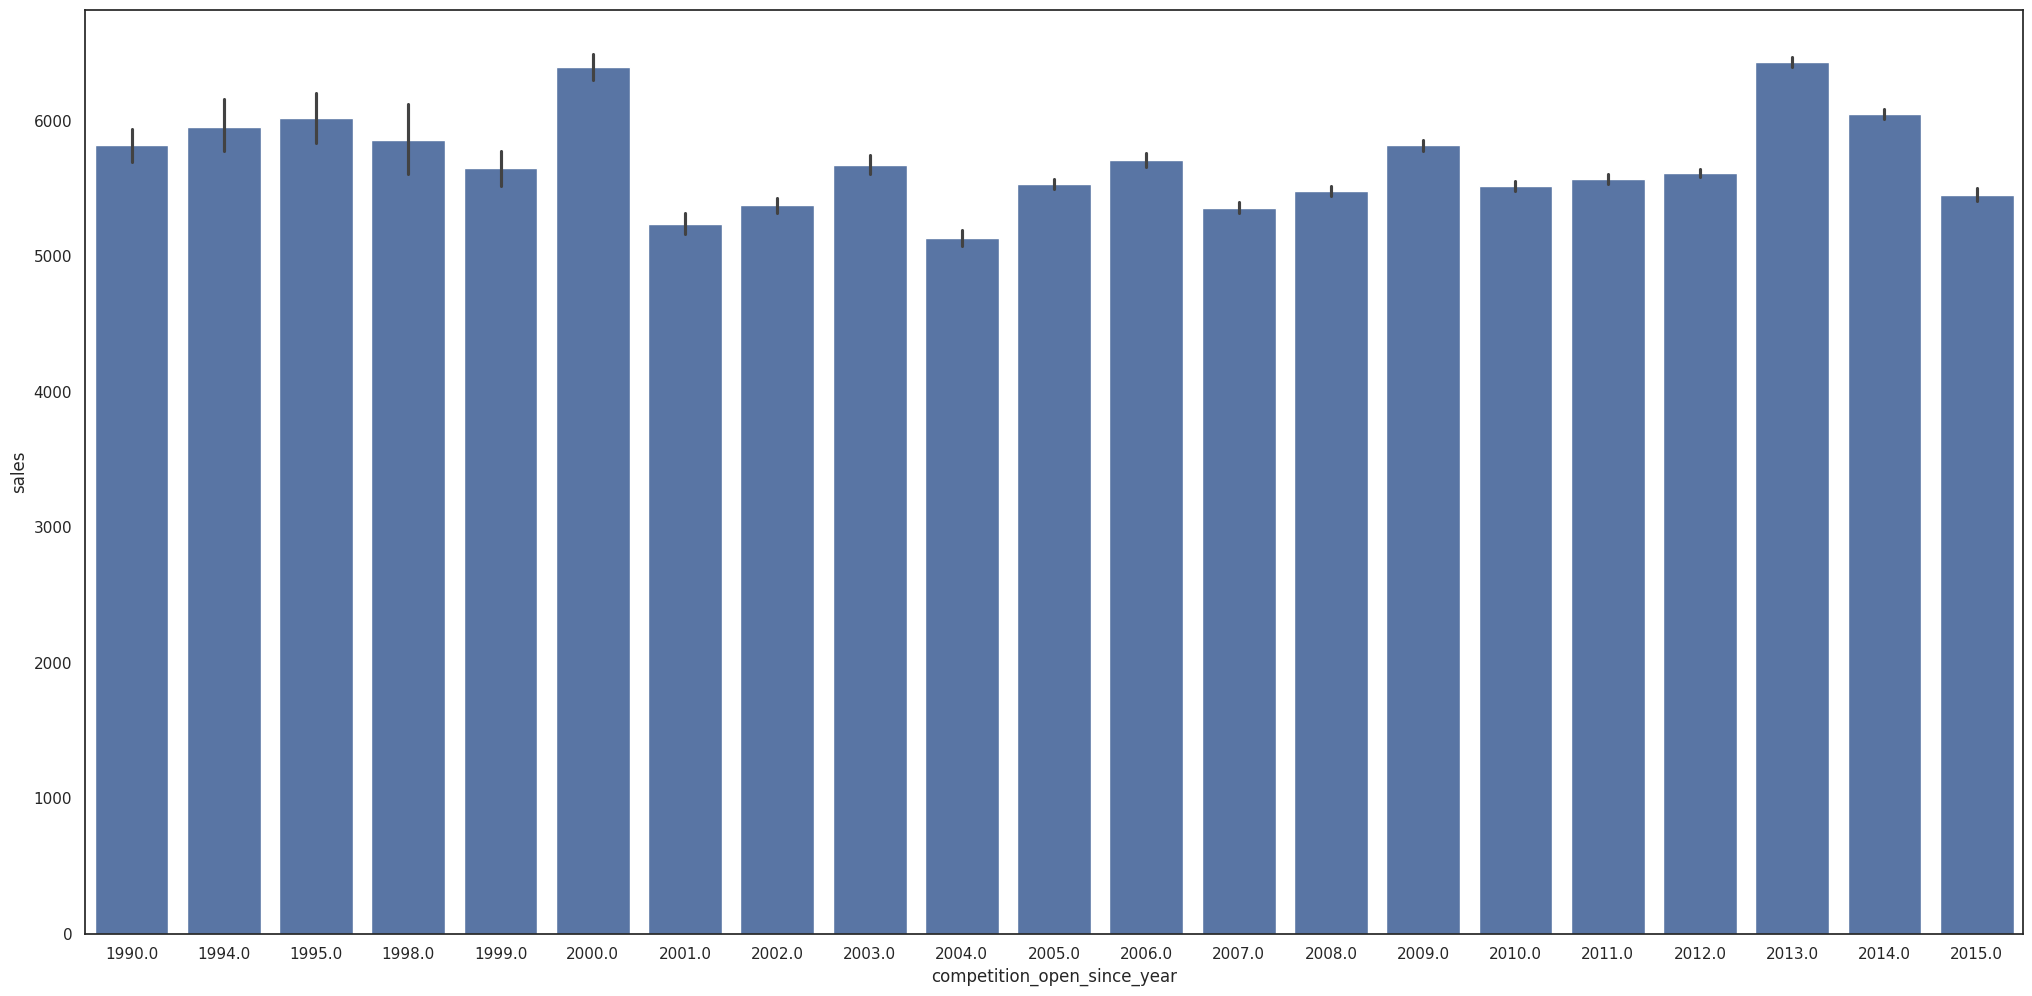

In [49]:
# Filter the data based on the condition
filtered_data = X_train.loc[X_train['competition_open_since_year'] > 1980]

# Plot the histogram
sns.barplot(x=filtered_data['competition_open_since_year'], y='sales', data=X_train)


### **H7.** Stores with with more consecutive sale should sell more.
**FALSE** Stores with more consecutive promotions sell less.

In [52]:
X_train[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

promo  promo2       sales
0      0       0   982162741
1      0       1   869228322
2      1       0  1036189803
3      1       1   951764377

## 2.3. Multivariate Analysis

### 2.3.1. Numerical Attributes

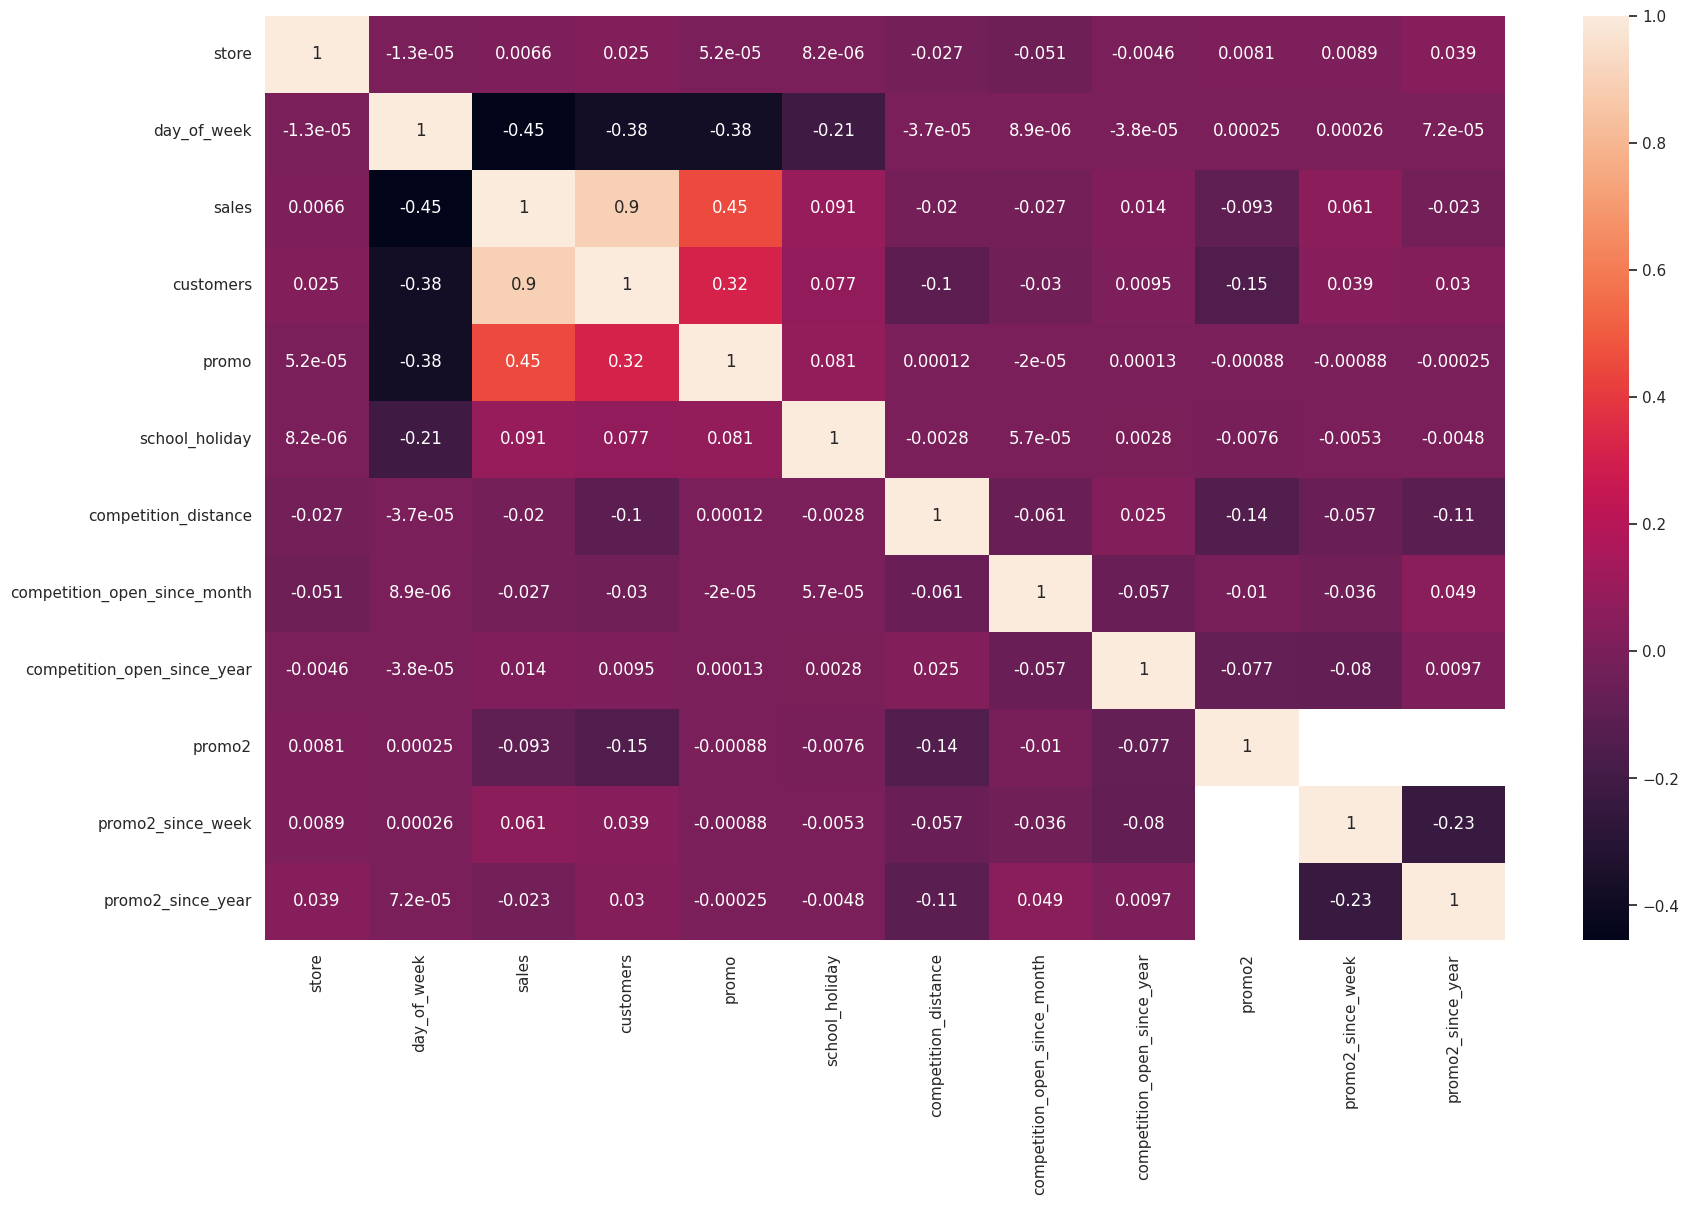

In [56]:
plt.figure(figsize=(20, 12))
num_attributes = num_attributes.drop('open', axis = 1)
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 2.3.2. Categorical Attributes

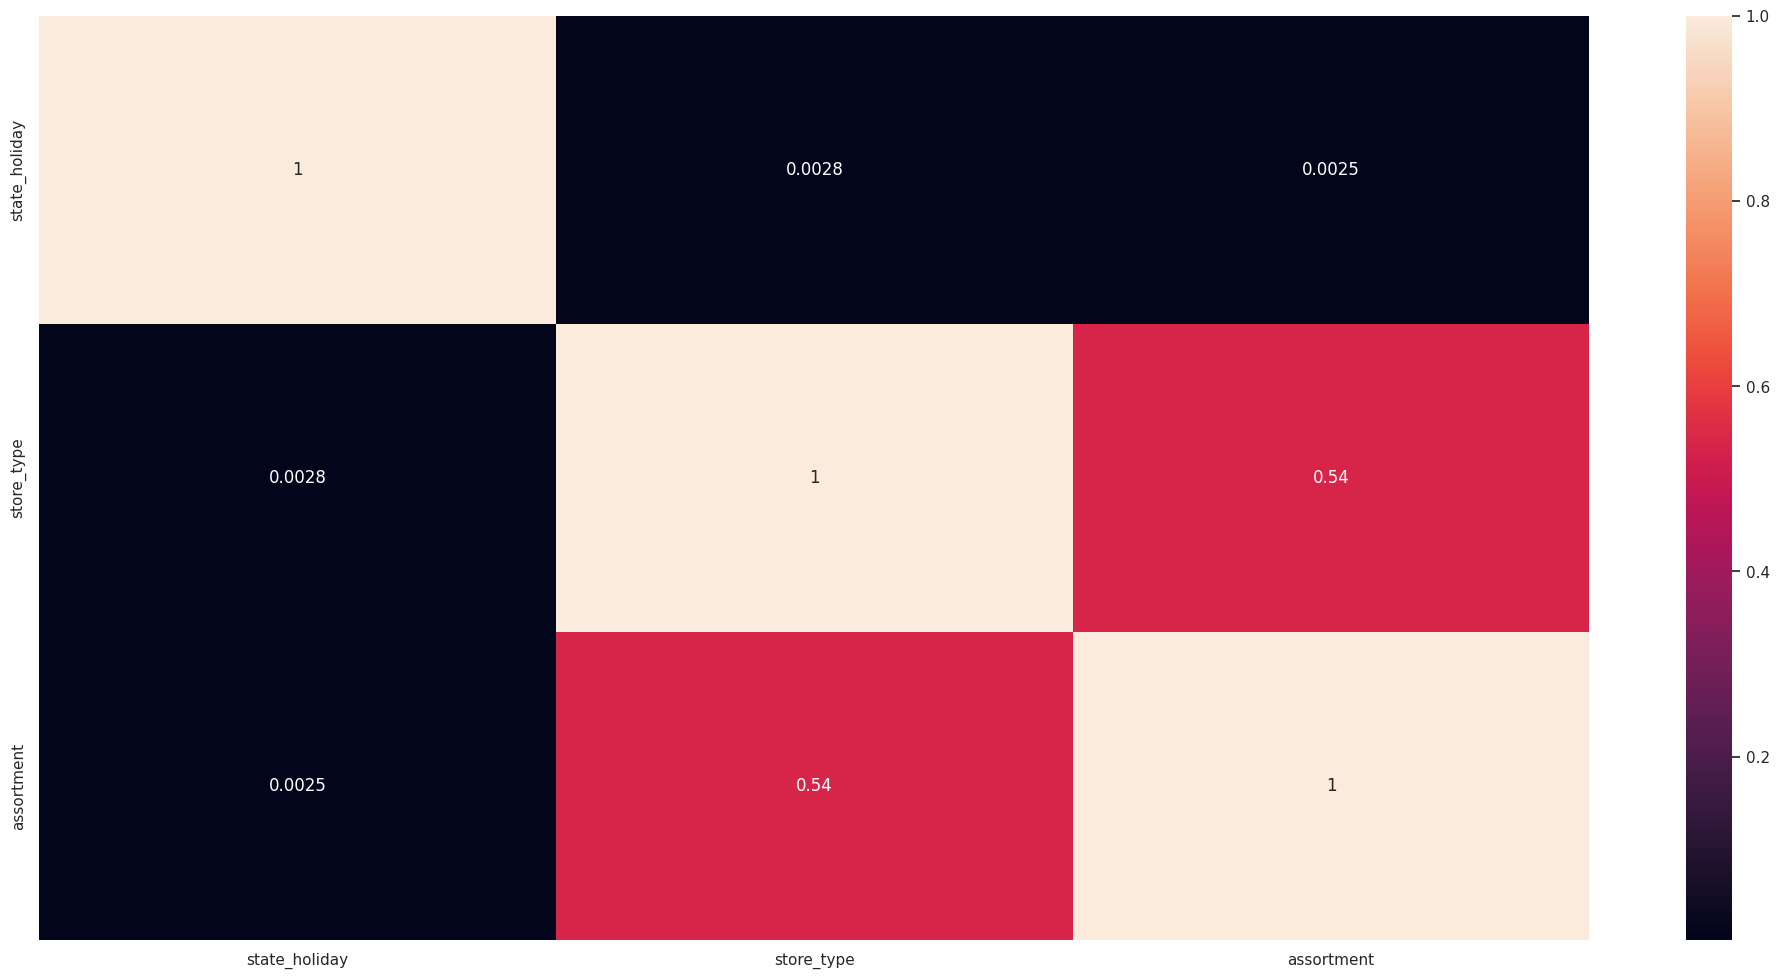

In [57]:
# Selecting categorical data
a = cat_attributes

# Calculating Cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

d = pd.DataFrame( {'state_holiday':[a1, a2, a3],
                'store_type':[a4, a5, a6],
                'assortment':[a7, a8, a9] } )

d = d.set_index( d.columns )

sns.heatmap( d, annot=True);

# 3.0. Feature Engineering

# 4.0. Machine Learning Modeling

## 4.1. Setting up the Pipeline

### 4.1.1. Auxiliary Functions Pipeline

In [5]:
# DEFINE WORKFLOW AND FUNCTIONS FOR PIPELINE USE

# 1 - TIME ATTRIBUTES
# Step -1; Engineer time attributes
def time_attr(dataframe):
    """
    Extracts time-based attributes from a DataFrame containing a 'date' column.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing a 'date' column from which time-based attributes
        will be extracted.

    Returns:
    --------
    pandas.DataFrame
        DataFrame with additional time-based attributes including 'year', 'month',
        'day', 'week_of_year', and 'year_week'.

    Notes:
    ------
    This function extracts various time-based attributes from a 'date' column in the
    input DataFrame, including year, month, day, week of the year, and year-week.
    The 'date' column is assumed to be in datetime format.

    Example:
    --------
    # Call the function to extract time-based attributes from the DataFrame df
    df_with_time_attrs = time_attr(df)
    """
    # Create a copy
    df = dataframe.copy()

    #Ensure th date variable is is proper format:
    df['date'] = pd.to_datetime(df['date'])

    # year
    df['year'] = df['date'].dt.year

    # month
    df['month'] = df['date'].dt.month

    # day
    df['day'] = df['date'].dt.day

    # week of year
    df['week_of_year'] = df['date'].dt.isocalendar().week

    # year week
    # df['year_week'] = df['date'].dt.strftime( '%Y-%W' )

    return df

# 2 - INPUT MISSING DATA USING kNN IMPUTER
# Step 0: Define your custom function
def data_imputer(dataframe):
    """
    Imputes missing values in specified columns of a DataFrame using KNNImputer.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing columns with missing values to be imputed.

    Returns:
    --------
    pandas.DataFrame
        DataFrame with missing values imputed using KNNImputer.

    Notes:
    ------
    This function scans the variables to check whether they have missing values from >0 to <10%. 
    Then, it replaces missing values in the specified columns of the input DataFrame
    using KNNImputer from the scikit-learn library. It imputes missing values based on
    the k-nearest neighbors of the data points with missing values. The number of neighbors
    used for imputation is set to 5 by default.

    Example:
    --------
    # Import required libraries
    from sklearn.impute import KNNImputer
    
    # Call the function to impute missing values in the DataFrame df
    df_imputed = data_imputer(df)
    """
    df = dataframe.copy()
    # Calculate the proportion of missing values for each column
    missing_proportions = df.isna().sum() / df.shape[0] * 100

    # Initialize an empty list to store column names with more than 10% missing values
    columns_with_missing = []

    # Iterate over each column's missing proportion
    for column, proportion in missing_proportions.items():
        if proportion > 10:
            # Drop column with moe than 10% missing
            df.drop(column, axis=1, inplace=True)
        elif 0 < proportion < 10:
            columns_with_missing.append(column)

    # Initialize KNNImputer
    imputer = KNNImputer(n_neighbors=5)

    # Impute missing values
    df[columns_with_missing] = imputer.fit_transform(df[columns_with_missing])

    return df

# 3 - FORMATTING THE CATEGORICAL VARIABLES
# Step 1: Define your custom function
def cat_format(df):
    """
    Formats categorical variables in the given DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame containing categorical variables.

    Returns:
        pandas.DataFrame: The DataFrame with formatted categorical variables.

    Example:
        df = cat_format(df)
    
    """
    # Fix data type
    df['competition_distance'] = df['competition_distance'].astype(int)
    
    # # assortment
    df['assortment'] = df['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

    # # state holiday
    df['state_holiday'] = (
        df['state_holiday']
        .apply(
            lambda x:
                'public_holiday' 
                if x == 'a' 
                else (
                    'easter_holiday' 
                    if x == 'b' 
                    else (
                        'christmas' 
                        if x == 'c' 
                        else 'regular_day'
                    )
                ) 
        )
    )
    return df

# 4 - RESCALING
def rescaling_vars(df):
    """
    Rescales numerical variables in the given DataFrame using RobustScaler and MinMaxScaler.

    Args:
        df (pandas.DataFrame): The input DataFrame containing numerical variables.

    Returns:
        pandas.DataFrame: The DataFrame with rescaled numerical variables.

    Example:
        df = rescaling_vars(df)
    """
    rs = RobustScaler() # rescaling the variable
    mms = MinMaxScaler()

    # # year
    df['year'] = mms.fit_transform( df[['year']])
    # Check for year scaling
    return df

# 5 - TRANSFORMATION:ENCODING

def encode_vars(df):
    """
    Encodes categorical variables in the given DataFrame using different techniques.

    Args:
        df (pandas.DataFrame): The input DataFrame containing categorical variables.

    Returns:
        pandas.DataFrame: The DataFrame with encoded variables.

    Example:
        df = encode_vars(df)
    """

    le = LabelEncoder()

    # state_holiday - One Hot Encoding
    df = pd.get_dummies( df, prefix=['state_holiday'], columns = ['state_holiday'] )

    # store_type - Label Encoding ORDINAL ENCODER
    df['store_type'] = le.fit_transform( df['store_type'] ) # VERIFY
    
    # assortment - Ordinal Encoding ORDINAL ENCODER
    df['assortment_encoded'] = le.fit_transform(df['assortment'])

    return df

# 6 - LOG-TRANSFORM RESPONSE VARIABLE
def log_trf_var(df):
    """
    Applies a natural logarithm transformation (log1p) to the 'sales' column in the given DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame containing the 'sales' column.

    Returns:
        pandas.DataFrame: The DataFrame with the transformed 'sales' column.

    Example:
        df = log_trf_var(df)
    """
    df['sales'] = np.log1p(df['sales'])

    return df


# 7 - NATURE TRANSFORMATION
def nature_transf_vars(df):
    """
    Apply trigonometric transformations to date-related columns in a DataFrame.

    Args:
        df (pandas.DataFrame): Input DataFrame containing columns 'day_of_week',
                              'month', 'day', and 'week_of_year'.

    Returns:
        pandas.DataFrame: Transformed DataFrame with additional columns:
            - 'day_of_week_sin' and 'day_of_week_cos': Sine and cosine of day of week.
            - 'month_sin' and 'month_cos': Sine and cosine of month.
            - 'day_sin' and 'day_cos': Sine and cosine of day.
            - 'week_of_year_sin' and 'week_of_year_cos': Sine and cosine of week of year.
    """
    # day of week
    df['day_of_week_sin'] = df['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
    df['day_of_week_cos'] = df['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

    # month
    df['month_sin'] = df['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
    df['month_cos'] = df['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

    # day 
    df['day_sin'] = df['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
    df['day_cos'] = df['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

    # week of year
    def weeks_in_year(year):
        if year % 4 == 0 and (year % 100 != 0 or year % 400 == 0):
            
            return 53  # Leap year
        else:
            return 52  # Non-leap year
        
    df['week_of_year_sin'] = df['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/weeks_in_year(x) ) ) )
    df['week_of_year_cos'] = df['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/weeks_in_year(x) ) ) )

    return df

# 8 - One Hot Encoder
def ohencoder(df, cat_vars=['state_holiday','assortment','store_type']):
    ohe = OneHotEncoder(sparse_output=False).set_output(transform='pandas')

    ohe_data = ohe.fit_transform(df[cat_vars])

    # Create DataFrame with the one-hot encoded features and column names
    encoded_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(cat_vars), index=df.index)

    # Concatenate the encoded DataFrame with the original DataFrame
    df_encoded = pd.concat([df, encoded_df], axis=1)
    df_encoded = df_encoded.drop(df_encoded[cat_vars], axis=1)

    return df_encoded

### 4.1.2. Load and preprocess data

In [6]:
%%time
df_sales_raw = pd.read_csv( config['data']['train_path'], low_memory=False )
df_store_raw = pd.read_csv( config['data']['store_path'], low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# Rename columns

df_raw = df_raw[[   'Store','DayOfWeek', 'Date', 'Customers', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval','Sales']]

# Format column names for convenience
############INLCUIR NO YAML##################
cols_old = ['Store', 'DayOfWeek', 'Date', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval','Sales']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df_raw.columns = cols_new

# Ensure that the date variable is in a proper format
df_raw['date'] = pd.to_datetime(df_raw['date'])

# Filter out data with no sales registered

df_raw = df_raw.loc[df_raw['sales'] != 0, :] #describe the why

# df_raw1 = df_raw.copy()
# df_raw1 = df_raw1.sample(n=1500, random_state=42)
df_raw = time_attr(df_raw)
df_raw = data_imputer(df_raw)
df_raw = cat_format(df_raw)
df_raw = nature_transf_vars(df_raw)
df_raw = ohencoder(df_raw)

######################################################################
######################################################################
#######$$$ Split the dataset into train, validation, and test$$$######
######################################################################
######################################################################

# Training dataset
X_train = df_raw[df_raw['date'] <= '2014-09-10'].drop(columns=['sales'])
y_train = df_raw.loc[df_raw['date'] <= '2014-09-10', 'sales']


# Validation dataset
X_val = df_raw[(df_raw['date'] >= '2014-09-11') & (df_raw['date'] <= '2015-06-18')].drop(columns=['sales'])
y_val = df_raw[(df_raw['date'] >= '2014-09-11') & (df_raw['date'] <= '2015-06-18')]['sales']


# Test dataset
X_test = df_raw[df_raw['date'] >= '2015-06-19'].drop(columns=['sales'])
y_test = df_raw[df_raw['date'] >= '2015-06-19']['sales']

print( f'Training Min Date: {X_train["date"].min()}')
print( f'Training Max Date: {X_train["date"].max()}')

print( f'\nValidation Min Date: {X_val["date"].min()}')
print( f'Validation Max Date: {X_val["date"].max()}')

print( f'\nTest Min Date: {X_test["date"].min()}')
print( f'Test Max Date: {X_test["date"].max()}')

print(f'X Train shape: {X_train.shape}')
print(f'y Train shape: {y_train.shape}')
print(f'X Val shape: {X_val.shape}')
print(f'y Val shape: {y_val.shape}')
print(f'X Test shape: {X_test.shape}')
print(f'y Test shape: {y_test.shape}')

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2014-09-10 00:00:00

Validation Min Date: 2014-09-11 00:00:00
Validation Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00
X Train shape: (561576, 32)
y Train shape: (561576,)
X Val shape: (241366, 32)
y Val shape: (241366,)
X Test shape: (41396, 32)
y Test shape: (41396,)
CPU times: user 1min 54s, sys: 47 s, total: 2min 41s
Wall time: 1min 14s


In [8]:
print(X_train.columns)
print(X_val.columns)
print(X_test.columns)

Index(['store', 'day_of_week', 'date', 'customers', 'open', 'promo',
       'school_holiday', 'competition_distance', 'promo2', 'year', 'month',
       'day', 'week_of_year', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
       'week_of_year_cos', 'state_holiday_christmas',
       'state_holiday_easter_holiday', 'state_holiday_public_holiday',
       'state_holiday_regular_day', 'assortment_basic', 'assortment_extended',
       'assortment_extra', 'store_type_a', 'store_type_b', 'store_type_c',
       'store_type_d'],
      dtype='object')
Index(['store', 'day_of_week', 'date', 'customers', 'open', 'promo',
       'school_holiday', 'competition_distance', 'promo2', 'year', 'month',
       'day', 'week_of_year', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
       'week_of_year_cos', 'state_holiday_christmas',
       'state_holiday_easter_holiday', 'state

### 4.1.3. Feature Selection Boruta

In [11]:
#Feature selection using Boruta algorithm on train data only

# Makin a copy of X_train
X_train_numeric = X_train.copy()

# Convert Timestamp columns to numerical representation
timestamp_columns = X_train.select_dtypes(include=['datetime64']).columns
for col in timestamp_columns:
    X_train_numeric[col] = (X_train[col] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')


rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs = -1)
boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2)
boruta_selector.fit_transform(X_train_numeric.values, y_train.values)

selected_features = X_train_numeric.columns[boruta_selector.support_]

fs = selected_features.to_list()
fs

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	21
Iteration: 	9 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	21
Iteration: 	10 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	21
Iteration: 	11 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	21
Iteration: 	12 / 100
Confirmed: 	9
Tentative: 	0
Rejected: 	23


BorutaPy finished running.

Iteration: 	13 / 100
Confirmed: 	9
Tentative: 	0
Rejected: 	23


['store',
 'customers',
 'promo',
 'competition_distance',
 'promo2',
 'assortment_basic',
 'assortment_extra',
 'store_type_b',
 'store_type_d']

In [20]:
# Boruta Feature selected
fs = ['store',
 'customers',
 'promo',
 'competition_distance',
 'promo2',
 'assortment_basic',
 'assortment_extra',
 'store_type_b',
 'store_type_d']

## 4.2. Linear Regression Model

In [13]:
# Define variables to preprocess
numerical_features = [
 'customers',
 'competition_distance',
 ]

# Create preprocesssing pipeline

numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        
    ])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['customers', 'competition_distance'])])

In [14]:
def random_search_with_metrics(model, model_name, X_train, y_train, X_val, y_val, preprocessor, fs):
    param_distributions = {
        'regressor__fit_intercept': [True, False],
        }

    regressor = model

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])

    tscv = TimeSeriesSplit(n_splits=5)
    
    results = []

    for train_index, val_index in tscv.split(X_train):
        # Cloning the pipeline to ensure a fresh model for each iteration
        pipeline_cloned = clone(pipeline)
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        random_search = RandomizedSearchCV(pipeline_cloned, param_distributions, n_iter=2, cv=tscv, scoring='neg_mean_squared_error', random_state=42)
        random_search.fit(X_train_fold[fs], y_train_fold)

        best_model = random_search.best_estimator_

        y_val_pred = best_model.predict(X_val_fold[fs])
        val_rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
        val_mae = mean_absolute_error(y_val_fold, y_val_pred)
        val_mape = mean_absolute_error(y_val_fold, y_val_pred) / y_val_fold.mean()

        results.append({
            'Validation RMSE': val_rmse,
            'Validation MAE': val_mae,
            'Validation MAPE': val_mape,
        })

    results_df = pd.DataFrame(results)

    metrics_mean = results_df.mean()
    metrics_std = results_df.std()

    summary_df = pd.DataFrame({
        'Model': model_name,
        'Metric': metrics_mean.index,
        'Mean': metrics_mean.values,
        'Standard Deviation': metrics_std.values
    })

    return summary_df, random_search

# Run modeling with random search cross-validation for Linear Regression
summary_df_lr, random_search = random_search_with_metrics(LinearRegression(n_jobs=-1), "Linear Regression", X_train, y_train, X_val, y_val, preprocessor, fs)

In [15]:
summary_df_lr

Model           Metric         Mean  Standard Deviation
0  Linear Regression  Validation RMSE  1702.390450          124.608370
1  Linear Regression   Validation MAE  1232.410954           72.118312
2  Linear Regression  Validation MAPE     0.180808            0.004660

In [16]:
print(f'Best parameters found:{random_search.best_params_}\n Best model found: {random_search.best_estimator_}')

Best parameters found:{'regressor__fit_intercept': True}
 Best model found: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['customers',
                                                   'competition_distance'])])),
                ('regressor', LinearRegression(n_jobs=-1))])


## 4.3. Linear Regression Regularized Model - Lasso

In [17]:
# Define variables to preprocess
numerical_features = [
 'customers',
 'competition_distance',
 ]

# Create preprocesssing pipeline

numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        
    ])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['customers', 'competition_distance'])])

In [18]:
def random_search_with_metrics(model, model_name, X_train, y_train, X_val, y_val, preprocessor, fs):
    param_distributions = {
        'regressor__alpha': [0.001, 0.01, 0.1, 1.0],
        'regressor__fit_intercept': [True, False],
        }

    regressor = model

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])

    tscv = TimeSeriesSplit(n_splits=5)
    
    results = []

    for train_index, val_index in tscv.split(X_train):
        # Cloning the pipeline to ensure a fresh model for each iteration
        pipeline_cloned = clone(pipeline)
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        random_search = RandomizedSearchCV(pipeline_cloned, param_distributions, n_iter=4, cv=tscv, scoring='neg_mean_squared_error', random_state=42)
        random_search.fit(X_train_fold[fs], y_train_fold)

        best_model = random_search.best_estimator_

        y_val_pred = best_model.predict(X_val_fold[fs])
        val_rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
        val_mae = mean_absolute_error(y_val_fold, y_val_pred)
        val_mape = mean_absolute_error(y_val_fold, y_val_pred) / y_val_fold.mean()

        results.append({
            'Model':model_name,
            'Validation RMSE': val_rmse,
            'Validation MAE': val_mae,
            'Validation MAPE': val_mape,
        })

    results_df = pd.DataFrame(results)

    metrics_mean = results_df.select_dtypes(include=[int, float]).mean()
    metrics_std = results_df.select_dtypes(include=[int, float]).std()

    summary_df = pd.DataFrame({
        'Model': model_name,
        'Metric': metrics_mean.index,
        'Mean': metrics_mean.values,
        'Standard Deviation': metrics_std.values
    })

    return summary_df, random_search

# Run modeling with random search cross-validation for Lasso Regression
summary_df_lasso, random_search = random_search_with_metrics(Lasso(), "Lasso Regression", X_train, y_train, X_val, y_val, preprocessor, fs)


In [19]:
summary_df_lasso

Model           Metric         Mean  Standard Deviation
0  Lasso Regression  Validation RMSE  1702.390804          124.609553
1  Lasso Regression   Validation MAE  1232.412945           72.118754
2  Lasso Regression  Validation MAPE     0.180808            0.004660

In [20]:
print(f'Best parameters found:{random_search.best_params_}\n Best model found: {random_search.best_estimator_}')

Best parameters found:{'regressor__fit_intercept': True, 'regressor__alpha': 0.001}
 Best model found: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['customers',
                                                   'competition_distance'])])),
                ('regressor', Lasso(alpha=0.001))])


## 4.4. Random Forest Regressor

In [21]:
# Define variables to preprocess
numerical_features = [
 'customers',
 'competition_distance',
 ]

# Create preprocesssing pipeline

numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        
    ])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['customers', 'competition_distance'])])

In [23]:
def random_search_with_metrics(model_name, X_train, y_train, X_val, y_val, preprocessor, fs):
    param_distributions = {
        'regressor__n_estimators': [25, 50, 100, 150],
        'regressor__max_depth': [5, 10, 15, 45]
    }

    regressor = RandomForestRegressor(n_jobs=-1)

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])

    tscv = TimeSeriesSplit(n_splits=5)
    
    results = []

    for train_index, val_index in tscv.split(X_train):
        # Clone the pipeline to ensure a fresh model for each iteration
        pipeline_cloned = clone(pipeline)
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        random_search = RandomizedSearchCV(pipeline_cloned, param_distributions, n_iter=10, cv=tscv, scoring='neg_mean_squared_error', random_state=42)
        random_search.fit(X_train_fold[fs], y_train_fold)

        best_model = random_search.best_estimator_

        y_val_pred = best_model.predict(X_val_fold[fs])
        val_rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
        val_mae = mean_absolute_error(y_val_fold, y_val_pred)
        val_mape = mean_absolute_error(y_val_fold, y_val_pred) / y_val_fold.mean()

        results.append({
            'Model': model_name,
            'Validation RMSE': val_rmse,
            'Validation MAE': val_mae,
            'Validation MAPE': val_mape,
        })

    results_df = pd.DataFrame(results)

    metrics_mean = results_df.select_dtypes(include=[int,float]).mean()
    metrics_std = results_df.select_dtypes(include=[int,float]).std()

    summary_df = pd.DataFrame({
        'Model': model_name,
        'Metric': metrics_mean.index,
        'Mean': metrics_mean.values,
        'Standard Deviation': metrics_std.values
    })

    return summary_df, random_search

# # Run modeling with random search cross-validation for Random Forest
summary_df_rf, random_search = random_search_with_metrics("Random Forest", X_train, y_train, X_val, y_val, preprocessor, fs)


In [21]:
summary_df_rf['Model'] = "Random Forest"
summary_df_rf = summary_df_rf[['Model','Metric','Mean','Standard Deviation']]

In [24]:
summary_df_rf

Model           Metric         Mean  Standard Deviation
0  Random Forest  Validation RMSE  1079.110899          108.753133
1  Random Forest   Validation MAE   708.754118           57.329059
2  Random Forest  Validation MAPE     0.103909            0.004505

In [25]:
print(f"Best parameters found: {random_search.best_params_}\nBest model found: {random_search.best_estimator_}")

Best parameters found: {'regressor__n_estimators': 150, 'regressor__max_depth': 45}
Best model found: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['customers',
                                                   'competition_distance'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=45, n_estimators=150,
                                       n_jobs=-1))])


Best parameters found:  {'regressor__max_depth': 45, 'regressor__n_estimators': 150}  
Best parameters found:  Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['customers',
                                                   'competition_distance'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=45, n_estimators=150))])

## 4.5. XGBoost Regressor

In [26]:
# Define variables to preprocess
numerical_features = [
 'customers',
 'competition_distance',
 ]

# Create preprocesssing pipeline

numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        
    ])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['customers', 'competition_distance'])])

In [27]:
def random_search_with_metrics(model_name, X_train, y_train, X_val, y_val, preprocessor, fs):
    param_distributions = {
        'regressor__n_estimators': [1500, 1700, 2500, 3000, 3500],
        'regressor__eta': [0.01, 0.03],
        'regressor__max_depth': [3, 5, 9],
        'regressor__subsample': [0.1, 0.3, 0.7],
        'regressor__colsample_bytee': [0.3, 0.7, 0.9],
        'regressor__learning_rate': [0.1, 0.01, 0.001],
        'regressor__min_child_weight': [3, 8, 15]
    }

    regressor = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1)

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])

    tscv = TimeSeriesSplit(n_splits=5)
    
    results = []

    for train_index, val_index in tscv.split(X_train):
        # Clone the pipeline to ensure a fresh model for each iteration
        pipeline_cloned = clone(pipeline)
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        random_search = RandomizedSearchCV(pipeline_cloned, param_distributions, n_iter=10, cv=tscv, scoring='neg_mean_squared_error', random_state=42)
        random_search.fit(X_train_fold[fs], y_train_fold)

        best_model = random_search.best_estimator_

        y_val_pred = best_model.predict(X_val_fold[fs])
        val_rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
        val_mae = mean_absolute_error(y_val_fold, y_val_pred)
        val_mape = mean_absolute_error(y_val_fold, y_val_pred) / y_val_fold.mean()

        results.append({
            'Validation RMSE': val_rmse,
            'Validation MAE': val_mae,
            'Validation MAPE': val_mape,
        })

    results_df = pd.DataFrame(results)

    metrics_mean = results_df.mean()
    metrics_std = results_df.std()

    summary_df = pd.DataFrame({
        'Model': model_name,
        'Metric': metrics_mean.index,
        'Mean': metrics_mean.values,
        'Standard Deviation': metrics_std.values
    })

    return summary_df, random_search

# Run modeling with random search cross-validation for XGBoost
summary_df_xgb, random_search = random_search_with_metrics("XGBoost", X_train, y_train, X_val, y_val, preprocessor, fs)


/home/thiago/.pyenv/versions/3.10.4/envs/ds_prod/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:36:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)


/home/thiago/.pyenv/versions/3.10.4/envs/ds_prod/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:36:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
/home/thiago/.pyenv/versions/3.10.4/envs/ds_prod/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:36:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
/home/thiago/.pyenv/versions/3.10.4/envs/ds_prod/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:36:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
/home/thiago/.pyenv/versions/3.10.4/envs/ds_prod/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:36:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)
/home/th

In [28]:
summary_df_xgb

Model           Metric         Mean  Standard Deviation
0  XGBoost  Validation RMSE  1171.468488          107.001142
1  XGBoost   Validation MAE   840.394283           50.487586
2  XGBoost  Validation MAPE     0.123301            0.003823

In [29]:
print(f'Best parameters found:{random_search.best_params_}\n Best model found:{random_search.best_estimator_}')

Best parameters found:{'regressor__subsample': 0.7, 'regressor__n_estimators': 1700, 'regressor__min_child_weight': 3, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.1, 'regressor__eta': 0.01, 'regressor__colsample_bytee': 0.7}
 Best model found:Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['customers',
                                                   'competition_distance'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytee=0.7, colsample_bytree=None,
                              device=None, early_stopping_rounds=Non...
                 

## 4.6. Comparing Models

In [30]:
summ_models = pd.concat([summary_df_lr, summary_df_lasso, summary_df_rf, summary_df_xgb])
summ_models

Model           Metric         Mean  Standard Deviation
0  Linear Regression  Validation RMSE  1702.390450          124.608370
1  Linear Regression   Validation MAE  1232.410954           72.118312
2  Linear Regression  Validation MAPE     0.180808            0.004660
0   Lasso Regression  Validation RMSE  1702.390804          124.609553
1   Lasso Regression   Validation MAE  1232.412945           72.118754
2   Lasso Regression  Validation MAPE     0.180808            0.004660
0      Random Forest  Validation RMSE  1079.110899          108.753133
1      Random Forest   Validation MAE   708.754118           57.329059
2      Random Forest  Validation MAPE     0.103909            0.004505
0            XGBoost  Validation RMSE  1171.468488          107.001142
1            XGBoost   Validation MAE   840.394283           50.487586
2            XGBoost  Validation MAPE     0.123301            0.003823

In [31]:
summ_models.to_csv('../data/summ_models.csv', index=False)

## 4.7. Final Model

In [32]:
param_tuned = {
    'n_estimators': 1700,
    'eta': 0.01,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytee': 0.7,
    'min_child_weight': 3, 
    'learning_rate': 0.1,
        }

In [33]:
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytee'],
                                    learning_rate=param_tuned['learning_rate'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( X_train[fs], y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( X_test[fs] )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor',  y_test, yhat_xgb_tuned )
xgb_result_tuned

/home/thiago/.pyenv/versions/3.10.4/envs/ds_prod/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:26:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)


Model Name         MAE      MAPE        RMSE
0  XGBoost Regressor  516.564681  0.070303  759.322647

# 5.0. Translating and Interpreting Error

In [43]:
df = X_test.copy()

df['sales'] = y_test
df['predictions'] = yhat_xgb_tuned
df.columns

Index(['store', 'day_of_week', 'date', 'customers', 'open', 'promo',
       'school_holiday', 'competition_distance', 'promo2', 'year', 'month',
       'day', 'week_of_year', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
       'week_of_year_cos', 'state_holiday_christmas',
       'state_holiday_easter_holiday', 'state_holiday_public_holiday',
       'state_holiday_regular_day', 'assortment_basic', 'assortment_extended',
       'assortment_extra', 'store_type_a', 'store_type_b', 'store_type_c',
       'store_type_d', 'sales', 'predictions'],
      dtype='object')

## 5.1. Business Performance

In [51]:
# sum of predictions
df91 = df[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

/tmp/ipykernel_35354/442976351.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df9_aux1 = df[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
/tmp/ipykernel_35354/442976351.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df9_aux2 = df[['store', 'sales', 'predictions']].groupby( 'store

In [46]:
df92.sort_values( 'MAPE', ascending=False ).head()

store   predictions  worst_scenario  best_scenario          MAE      MAPE
908    909  272905.46875   268882.940026  276927.997474  4022.528724  0.213310
875    876  199802.81250   197134.759893  202470.865107  2668.052607  0.180063
291    292  102027.96875    99960.993395  104094.944105  2066.975355  0.151178
125    126  222957.12500   222238.066129  223676.183871   719.058871  0.147254
695    696  288310.40625   286963.366501  289657.445999  1347.039749  0.143687

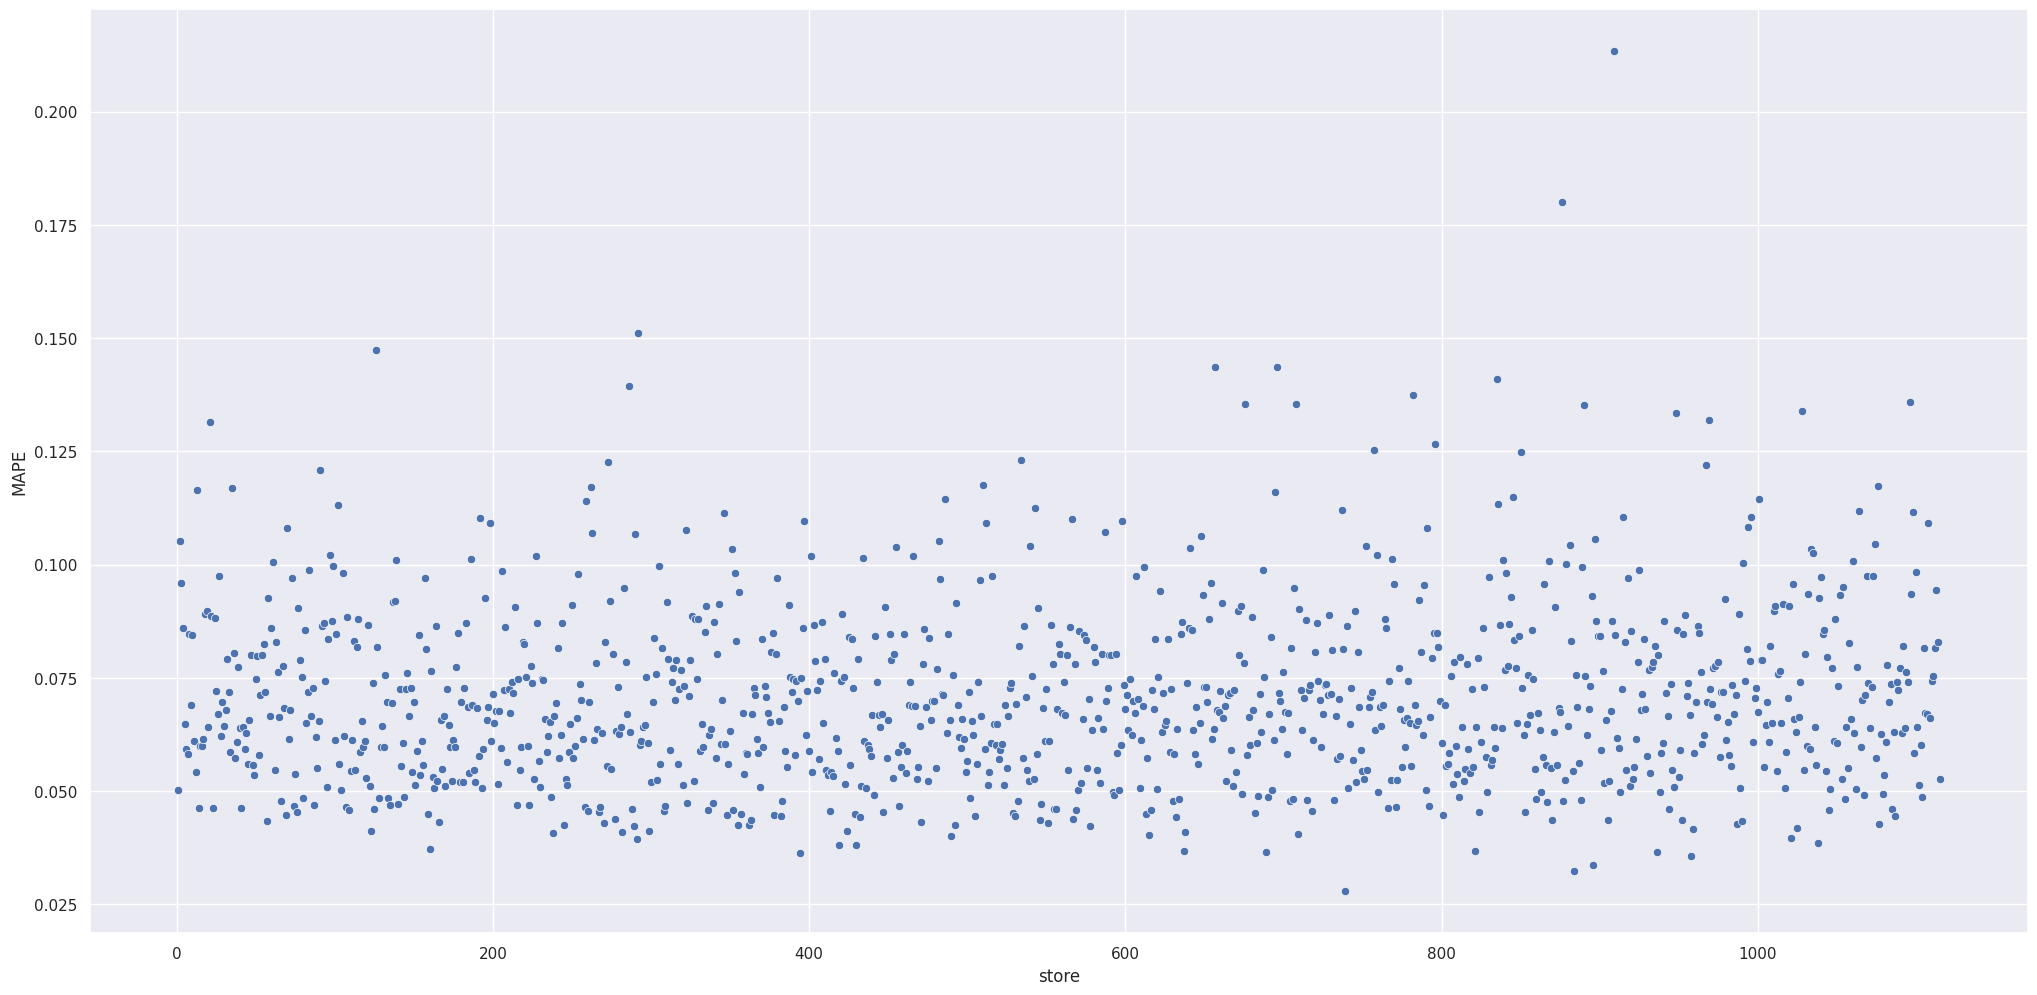

In [47]:
sns.scatterplot( x='store', y='MAPE', data=df92 )
sns.set_style(style='white')

## 5.2. Overall Performance

In [52]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

Scenario            Values
0     predictions  R$273,555,136.00
1  worst_scenario  R$272,977,310.74
2   best_scenario  R$274,133,016.65

## 5.3. Machine Learning Performance

In [54]:
df['error'] = df['sales'] - df['predictions']
df['error_rate'] = df['predictions'] / df['sales']

/home/thiago/.pyenv/versions/3.10.4/envs/ds_prod/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/thiago/.pyenv/versions/3.10.4/envs/ds_prod/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/thiago/.pyenv/versions/3.10.4/envs/ds_prod/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/thiago/.pyenv/versions/3.10.4/envs/ds_prod/lib/python3.10/site-packages/seaborn/_oldcore.py

<Axes: xlabel='predictions', ylabel='error'>

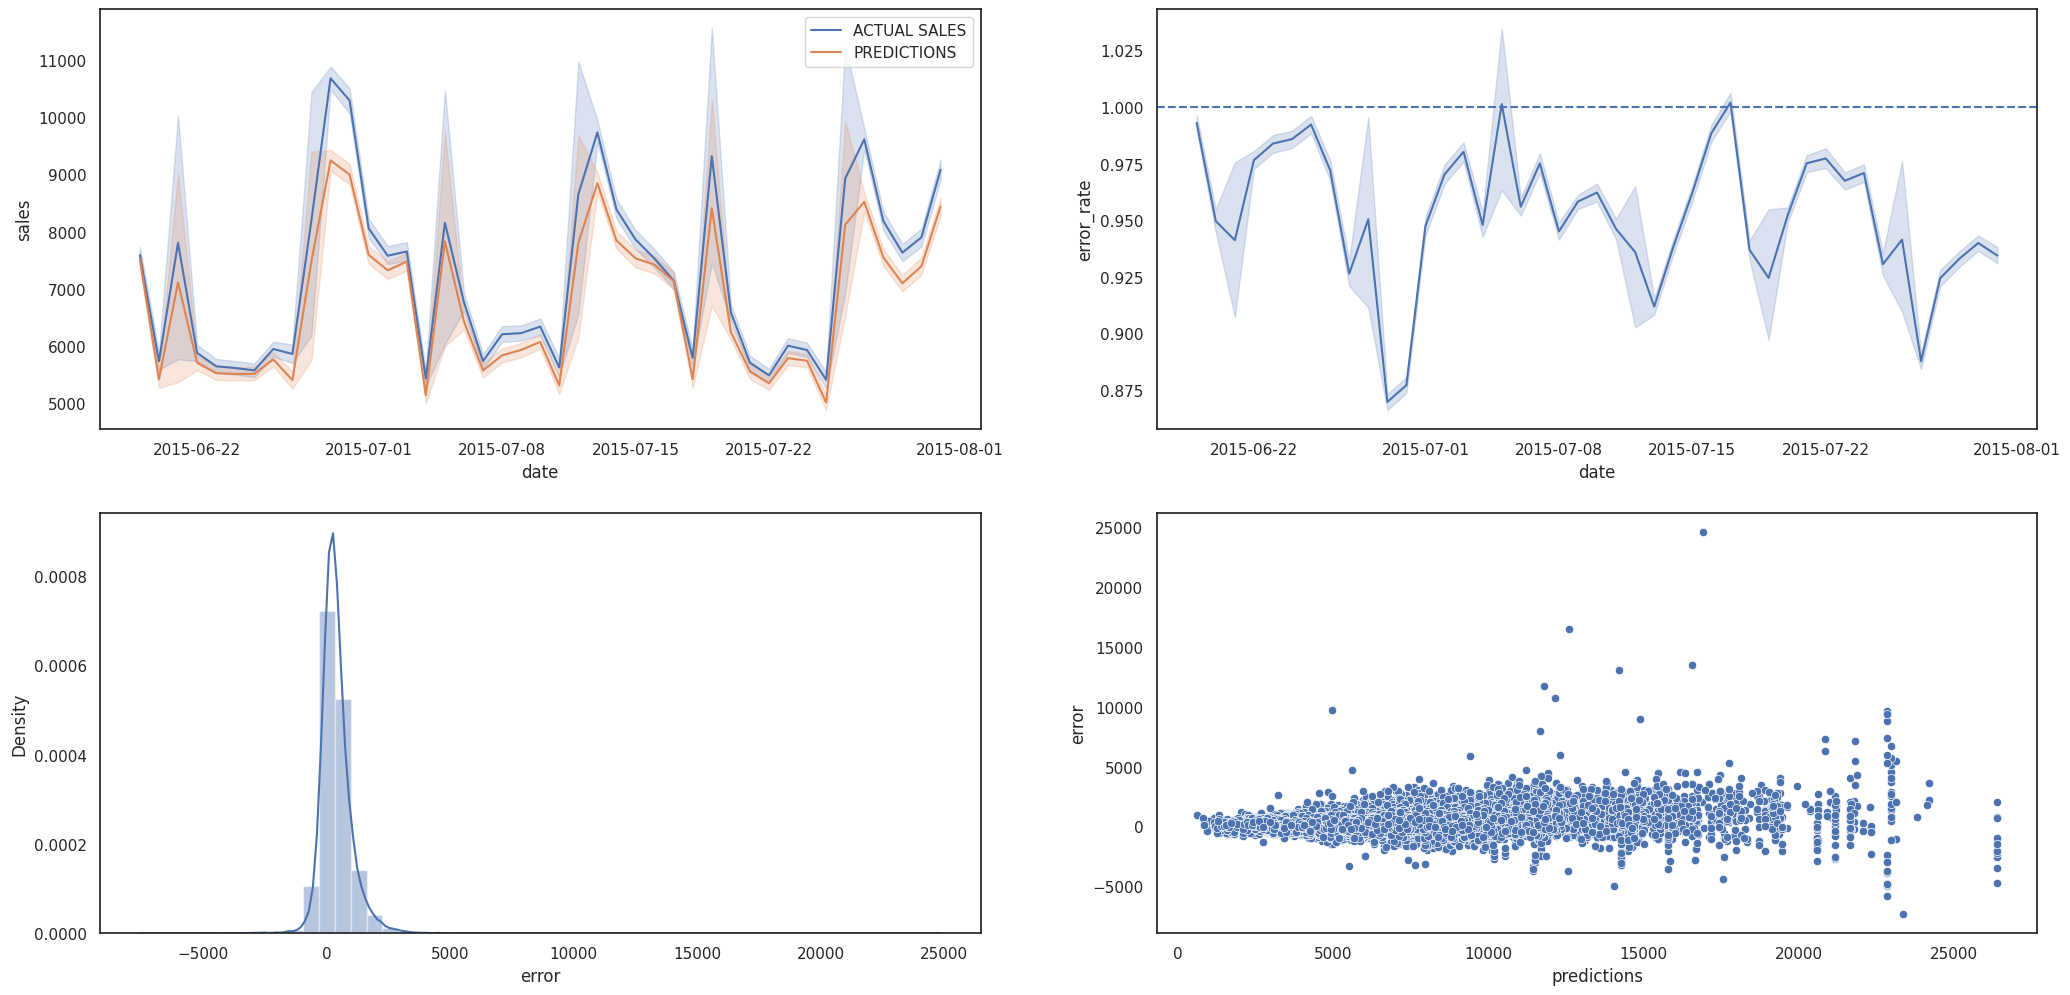

In [57]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df, label='ACTUAL SALES' )
sns.lineplot( x='date', y='predictions', data=df, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( x='predictions', y='error', data=df )

# 6.0. Deploy Model to Production

In [59]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open( '../model/model_rossmann.pkl', 'wb' ) )

## 6.1. DS Prod Class

In [ ]:
import inflection
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, OneHotEncoder


class DSProd( object ):
    """
    Class for data preprocessing and feature engineering for a machine learning prediction project.
    """

    def __init__(self):
        """
        Initialize DSProd object.
        """
        pass

    def data_cleaning(self, df):
        """
        Clean the input DataFrame by formatting column names and removing rows with zero sales.

        Parameters:
        -----------
        df : pandas.DataFrame
            Input DataFrame to be cleaned.

        Returns:
        --------
        pandas.DataFrame
            Cleaned DataFrame.
        """

        # Format column names for convenience
        cols_old = ['Store'              ,'DayOfWeek'                ,'Date'                    ,
                    'Customers'          ,'Open'                     ,'Promo', 'StateHoliday'   ,
                    'SchoolHoliday'      ,'StoreType'                ,'Assortment'              ,
                    'CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear',
                    'Promo2'             ,'Promo2SinceWeek'          ,'Promo2SinceYear'         ,
                    'PromoInterval'      ,'Sales']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df.columns = cols_new

        # Ensure that the date variable is in a proper format
        df['date'] = pd.to_datetime(df['date'])

        # Filter out data with no sales registered
        df = df.loc[df['sales'] != 0, :]

        return df


    def time_attributes(self, df):
        """
        Extracts time-based attributes from a DataFrame containing a 'date' column.

        Parameters:
        -----------
        df : pandas.DataFrame
            Input DataFrame containing a 'date' column from which time-based attributes
            will be extracted.

        Returns:
        --------
        pandas.DataFrame
            DataFrame with additional time-based attributes including 'year', 'month',
            'day', 'week_of_year', and 'year_week'.

        Notes:
        ------
        This function extracts various time-based attributes from a 'date' column in the
        input DataFrame, including year, month, day, week of the year, and year-week.
        The 'date' column is assumed to be in datetime format.

        Example:
        --------
        # Call the function to extract time-based attributes from the DataFrame df
        df_with_time_attrs = time_attr(df)
        """
        #Ensure th date variable is is proper format:
        df['date'] = pd.to_datetime(df['date'])

        # year
        df['year'] = df['date'].dt.year

        # month
        df['month'] = df['date'].dt.month

        # day
        df['day'] = df['date'].dt.day

        # week of year
        df['week_of_year'] = df['date'].dt.isocalendar().week

        return df


    def data_imputer(self, df):
        """
        Imputes missing values in specified columns of a DataFrame using KNNImputer.

        Parameters:
        -----------
        df : pandas.DataFrame
            Input DataFrame containing columns with missing values to be imputed.

        Returns:
        --------
        pandas.DataFrame
            DataFrame with missing values imputed using KNNImputer.

        Notes:
        ------
        This function scans the variables to check whether they have missing values from >0 to <10%. 
        Then, it replaces missing values in the specified columns of the input DataFrame
        using KNNImputer from the scikit-learn library. It imputes missing values based on
        the k-nearest neighbors of the data points with missing values. The number of neighbors
        used for imputation is set to 5 by default.

        Example:
        --------
        # Import required libraries
        from sklearn.impute import KNNImputer

        # Call the function to impute missing values in the DataFrame df
        df_imputed = data_imputer(df)
        """
        # Calculate the proportion of missing values for each column
        missing_proportions = df.isna().sum() / df.shape[0] * 100

        # Initialize an empty list to store column names with more than 10% missing values
        columns_with_missing = []

        # Iterate over each column's missing proportion
        for column, proportion in missing_proportions.items():
            if proportion > 10:
                # Drop column with moe than 10% missing
                df.drop(column, axis=1, inplace=True)
            elif 0 < proportion < 10:
                columns_with_missing.append(column)

        # Initialize KNNImputer
        imputer = KNNImputer(n_neighbors=5)

        # Impute missing values
        df[columns_with_missing] = imputer.fit_transform(df[columns_with_missing])

        return df

    def categorical_format(self, df):
        """
        Formats categorical variables in the given DataFrame.

        Args:
            df (pandas.DataFrame): The input DataFrame containing categorical variables.

        Returns:
            pandas.DataFrame: The DataFrame with formatted categorical variables.

        Example:
            df = cat_format(df)

        """
        # Fix data type
        df['competition_distance'] = df['competition_distance'].astype(int)

        # # assortment
        df['assortment'] = df['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # # state holiday
        df['state_holiday'] = df['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        return df

    def rescaling_vars(self, df):
        """
        Rescales numerical variables in the given DataFrame using RobustScaler and MinMaxScaler.

        Args:
            df (pandas.DataFrame): The input DataFrame containing numerical variables.

        Returns:
            pandas.DataFrame: The DataFrame with rescaled numerical variables.

        Example:
            df = rescaling_vars(df)
        """
        mms = MinMaxScaler()

        # # year
        df['year'] = mms.fit_transform( df[['year']])

        return df

    def encode_vars(self, df):
        """
        Encodes categorical variables in the given DataFrame using different techniques.

        Args:
            df (pandas.DataFrame): The input DataFrame containing categorical variables.

        Returns:
            pandas.DataFrame: The DataFrame with encoded variables.

        Example:
            df = encode_vars(df)
        """

        le = LabelEncoder()

        # state_holiday - One Hot Encoding
        df = pd.get_dummies( df, prefix=['state_holiday'], columns = ['state_holiday'] )

        # store_type - Label Encoding
        df['store_type'] = le.fit_transform( df['store_type'] )

        # assortment - Ordinal Encoding
        df['assortment_encoded'] = le.fit_transform(df['assortment'])

        return df

    def log_transform_vars(self, df):
        """
        Applies a natural logarithm transformation (log1p) to the 'sales' column in the given DataFrame.

        Args:
            df (pandas.DataFrame): The input DataFrame containing the 'sales' column.

        Returns:
            pandas.DataFrame: The DataFrame with the transformed 'sales' column.

        Example:
            df = log_trf_var(df)
        """
        df['sales'] = np.log1p(df['sales'])

        return df

    def nature_transform_vars(self, df):
        """
        Apply trigonometric transformations to date-related columns in a DataFrame.

        Args:
            df (pandas.DataFrame): Input DataFrame containing columns 'day_of_week',
                                  'month', 'day', and 'week_of_year'.

        Returns:
            pandas.DataFrame: Transformed DataFrame with additional columns:
                - 'day_of_week_sin' and 'day_of_week_cos': Sine and cosine of day of week.
                - 'month_sin' and 'month_cos': Sine and cosine of month.
                - 'day_sin' and 'day_cos': Sine and cosine of day.
                - 'week_of_year_sin' and 'week_of_year_cos': Sine and cosine of week of year.
        """
        # day of week
        df['day_of_week_sin'] = df['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df['day_of_week_cos'] = df['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df['month_sin'] = df['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df['month_cos'] = df['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df['day_sin'] = df['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df['day_cos'] = df['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        def weeks_in_year(year):
            if year % 4 == 0 and (year % 100 != 0 or year % 400 == 0):

                return 53  # Leap year
            else:
                return 52  # Non-leap year

        df['week_of_year_sin'] = df['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/weeks_in_year(x) ) ) )
        df['week_of_year_cos'] = df['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/weeks_in_year(x) ) ) )

        return df

    def one_hot_encoder(self, df, cat_vars=['state_holiday','assortment','store_type']):
        ohe = OneHotEncoder(sparse_output=False).set_output(transform='pandas')

        ohe_data = ohe.fit_transform(df[cat_vars])

        # Create DataFrame with the one-hot encoded features and column names
        encoded_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(cat_vars), index=df.index)

        # Concatenate the encoded DataFrame with the original DataFrame
        df_encoded = pd.concat([df, encoded_df], axis=1)
        df_encoded = df_encoded.drop(df_encoded[cat_vars], axis=1)
        df = df_encoded

        return df
    
    def get_prediction( self, model, df, test_data ):
        """
        Generate predictions using a trained model and input DataFrame.

        Parameters:
        -----------
        model : object
            Trained machine learning model for prediction.
        df : pandas.DataFrame
            Input DataFrame containing features.
        test_data : array-like
            Test data for prediction.

        Returns:
        --------
        str
            JSON representation of the DataFrame with predictions.
        """
        # prediction
        pred = model.predict( test_data )

        # join pred into the original data
        df['prediction'] = np.expm1( pred )

        return df.to_json( orient='records', date_format='iso' )


## 6.2. API Handler

In [6]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.DSProd import DSProd

model = pickle.load(open('/media/thiago/thiago_1tb/thiago/2022/data_science/seja_um_data_scientist/CDS/data_formation/ds_em_producao/ds_producao_projeto/model/model_rossmann.pkl','rb'))

app = Flask(__name__)

@app.route('/api/rossmann/predict', methods = ['POST'])

def rossmann_predict():
    test_json = request.get_json()

    if test_json:
        if isinstance( test_json, dict ):
            test_raw = pd.DataFrame (test_json, index = [0])
        
        else:
            test_raw = pd.DataFrame (test_json, columns = test_json[0].keys())

        # Instantiate DS Prod class
        pipeline = DSProd()

        # Data Cleaning
        df1  = pipeline.data_cleaning( test_raw )

        # Engineer time attributes
        df2  = pipeline.time_attributes ( df1 )

        # Impute missing data
        df3  = pipeline.data_imputer ( df2 )

        # Format categorical variables
        df4  = pipeline.categorical_format ( df3 )

        # Rescale selected variables
        df5  = pipeline.rescaling_vars ( df4 )

        # Encode selected variables
        df6  = pipeline.encode_vars ( df5 )

        # Log-transform the target variable 
        df7  = pipeline.log_transform_vars ( df6 )

        # Nature transform the cyclical variables
        df8  = pipeline.nature_transform_vars ( df7 )

        # One hot encode selected variables
        df9  = pipeline.one_hot_encoder ( df8 )

        # Prediction
        df_response = pipeline.get_prediction ( model, test_raw, df9 )

        return df_response.to_json(orient = 'records', date_format='iso'), 200, {'Content-Type':'application/json'}
    
    else:
        return Response( '{}'.format(test_json), status = 200, mimetype = 'application/json')
    
if  __name__ == '__main__':
    app.run( '0.0.0.0', debug = False)

ModuleNotFoundError: No module named 'rossmann'

## 6.3. API Tester

In [7]:
import json
import requests
import pandas as pd

In [8]:
# Loading test dataset
df10 = pd.read_csv( config['data']['test_path'], low_memory=False )
df_store = pd.read_csv( config['data']['store_path'], low_memory=False )

df10.head()

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17   1.0      1            0              0
1   2      3          4  2015-09-17   1.0      1            0              0
2   3      7          4  2015-09-17   1.0      1            0              0
3   4      8          4  2015-09-17   1.0      1            0              0
4   5      9          4  2015-09-17   1.0      1            0              0

In [9]:
# Merge test and store data sets
df_test = pd.merge(df10, df_store, how = 'left', on='Store')

In [10]:
# Choose store for prediction
df_test = df_test[df_test['Store'] == 22]

In [11]:
# Remove days closed
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [12]:
# Convert DataFrame to json
data = json.dumps(df_test.to_dict(orient = 'records'))

In [13]:
# API Call
url = 'http://0.0.0.0:5000/api/rossmann/predict'
header = {'Content-type':'application/json'}
data = data

r = requests.post(url, data = data, headers = header)
print(f'Status_code:{r.status_code}')

Status_code:500


In [14]:
df_test.columns

Index(['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [15]:
import os

In [16]:
os.chdir('/media/thiago/thiago_1tb/thiago/2022/data_science/seja_um_data_scientist/CDS/data_formation/ds_em_producao/ds_producao_projeto/api/rossmann')

In [17]:
from DSProd import DSProd

In [18]:
pipeline = DSProd()

df1 = pipeline.data_cleaning(df_test)

In [19]:
df2 = pipeline.time_attributes(df1)

In [20]:
df3 = pipeline.data_imputer(df2)

No columns with missing found. Skipping imputation.


In [21]:
df4 = pipeline.categorical_format(df3)

In [22]:
df5 = pipeline.rescaling_vars(df4)

In [23]:
df6 = pipeline.encode_vars(df5)

In [24]:
df7 = pipeline.log_transform_vars(df6)

In [25]:
df8 = pipeline.nature_transform_vars(df7)

In [26]:
df9 = pipeline.one_hot_encoder(df8)

In [27]:
model = pickle.load(open('/media/thiago/thiago_1tb/thiago/2022/data_science/seja_um_data_scientist/CDS/data_formation/ds_em_producao/ds_producao_projeto/model/model_rossmann.pkl','rb'))


# Prediction
df_response = pipeline.get_prediction ( model, df_test, df9 )

ValueError: feature_names mismatch: ['store', 'customers', 'promo', 'competition_distance', 'promo2', 'assortment_basic', 'assortment_extra', 'store_type_b', 'store_type_d'] ['store', 'day_of_week', 'open', 'promo', 'school_holiday', 'competition_distance', 'promo2', 'promo2_since_week', 'promo2_since_year', 'year', 'month', 'day', 'week_of_year', 'assortment_encoded', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos', 'state_holiday_regular_day', 'assortment_basic', 'store_type_0']
expected store_type_d, customers, assortment_extra, store_type_b in input data
training data did not have the following fields: month_cos, open, month_sin, promo2_since_year, store_type_0, day_of_week, day, assortment_encoded, year, week_of_year_sin, week_of_year_cos, day_of_week_cos, day_sin, promo2_since_week, week_of_year, school_holiday, state_holiday_regular_day, day_of_week_sin, month, day_cos

In [28]:
df8.columns



Index(['store', 'day_of_week', 'date', 'open', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'promo2', 'promo2_since_week', 'promo2_since_year', 'promo_interval',
       'year', 'month', 'day', 'week_of_year', 'assortment_encoded',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos'],
      dtype='object')